# TCR diagnosis

In this notebook we demonstrate how to diagnose the TCR for CMIP6 models using our data.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import glob
import os
import os.path
import requests
import shutil
import zipfile

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm.autonotebook as tqdman
import netcdf_scm.io
from openscm_units import unit_registry
from scmdata import ScmRun

/Users/znicholls/miniconda3/envs/calibration-data/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


<IPython.core.display.Javascript object>

In [3]:
def force_first_year(inp, new_first_year_value=1):
    ts = inp.timeseries()
    first_year = inp["year"].min()
    ts.columns = ts.columns.map(
        lambda x: dt.datetime(
            x.year - first_year + new_first_year_value, x.month, x.day
        )
    )

    out = ScmRun(ts)
    out.metadata = inp.metadata

    return out

<IPython.core.display.Javascript object>

## Download the data

First we need to download the tas data for the 1pctCO2 experiment. Here we want to use the normalised data i.e. timeseries which are anomalies from a 21-year running mean of the piControl. We also use the annual-mean data.

In [4]:
FORCE_DOWNLOAD = False

<IPython.core.display.Javascript object>

In [5]:
DATA_DIR = os.path.join(".", "tas_1pctCO2_data")
DATA_DIR

'./tas_1pctCO2_data'

<IPython.core.display.Javascript object>

In [6]:
zip_file = os.path.join(".", "tas_1pctCO2.zip")
zip_file

'./tas_1pctCO2.zip'

<IPython.core.display.Javascript object>

In [7]:
if FORCE_DOWNLOAD:
    os.remove(zip_file)

if not os.path.isfile(zip_file):
    print("Downloading tas 1pctCO2 data")
    params = (
        ("experiment_id", "1pctCO2"),
        ("variable_id", "tas"),
        ("normalised", "21-yr-running-mean"),
        ("timeseriestype", "average-year-mid-year"),
    )
    url = "https://cmip6.science.unimelb.edu.au/api/v1/download_zip"
    r = requests.get(url, params=params)

    with open(zip_file, "wb") as f:
        f.write(r.content)

<IPython.core.display.Javascript object>

In [8]:
if FORCE_DOWNLOAD:
    shutil.rmtree(DATA_DIR)

if not os.path.isdir(DATA_DIR):
    print("Unzipping data")
    zip_ref = zipfile.ZipFile(zip_file, "r")
    zip_ref.extractall(DATA_DIR)
    zip_ref.close()

Unzipping data


<IPython.core.display.Javascript object>

### README

Before using the data, please examine the README

In [9]:
with open(os.path.join(DATA_DIR, "README.txt"), "r") as fh:
    print(fh.read())

README
------

Acknowledging CMIP

The data provided here are derived from the outputs of the `Coupled Model Intercomparison Project <https://www.wcrp-climate.org/wgcm-cmip>`_ data.
This means that you **must** abide by the terms of use of the data, in particular the required acknowledgement statements (see the `CMIP5 terms of use <https://pcmdi.llnl.gov/mips/cmip5/terms-of-use.html>`_ and `CMIP6 terms of use <https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html>`_).

To make it easier to do this, we have developed some basic tools which simplify the process of checking model license terms and creating the tables required in publications to cite CMIP data (see the `our tools here <https://netcdf-scm.readthedocs.io/en/latest/usage/using-cmip-data.html>`_).
However, we provide no guarantees that these tools are up to date so all users should double check that they do in fact produce output consistent with the terms of use referenced above (and if there are issues, please raise an i

<IPython.core.display.Javascript object>

## Making plots

In [10]:
onepctCO2_tas_files = sorted(
    glob.glob(
        os.path.join(
            DATA_DIR, "average-year-mid-year", "**", "NORMED*tas*_1pctCO2_*.MAG"
        ),
        recursive=True,
    )
)
len(onepctCO2_tas_files)

76

<IPython.core.display.Javascript object>

  0%|          | 0/76 [00:00<?, ?it/s]

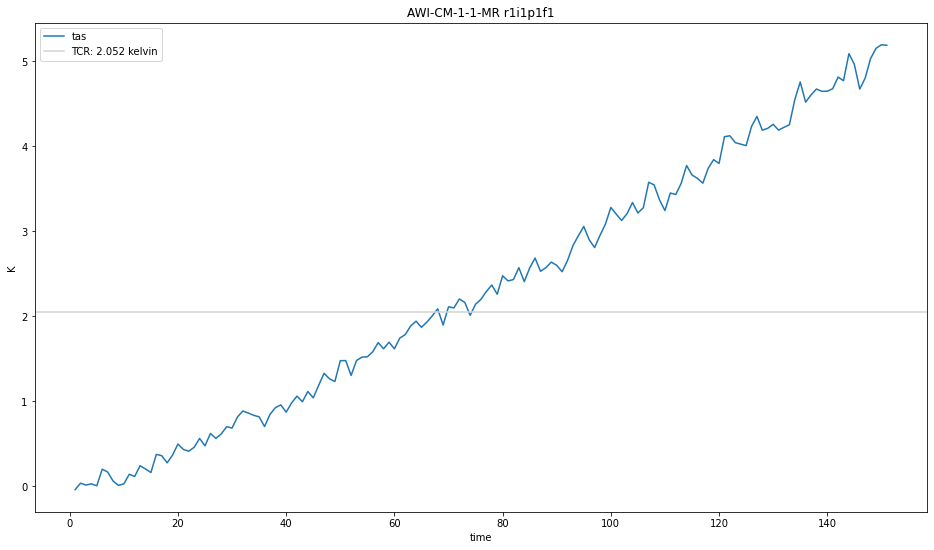

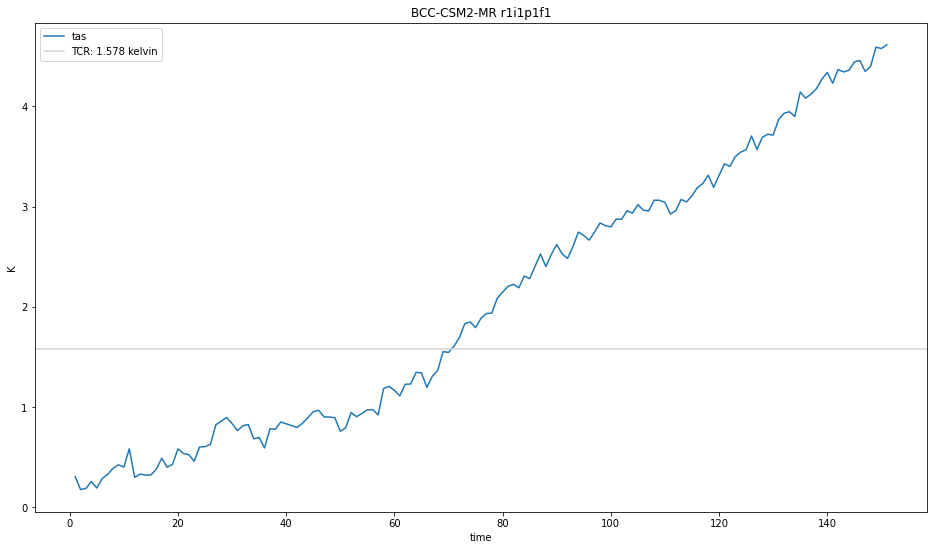

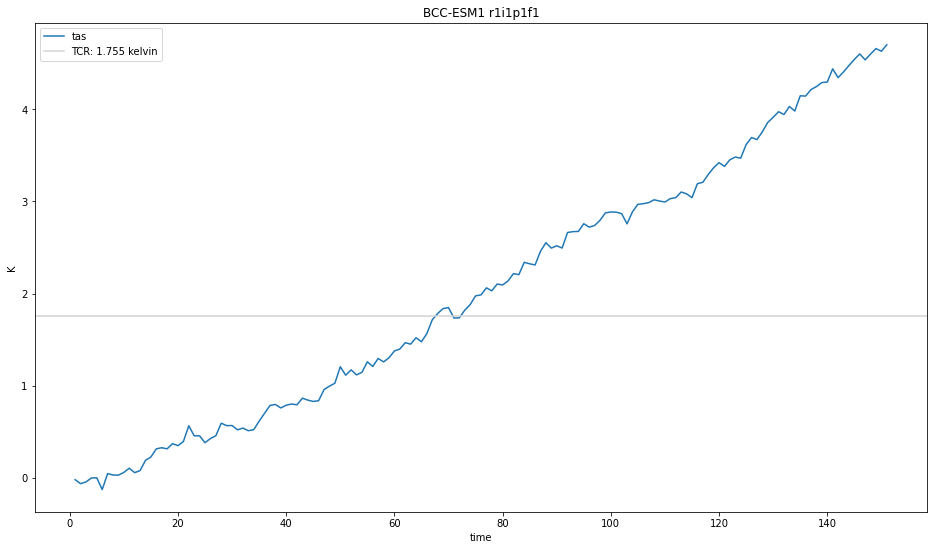

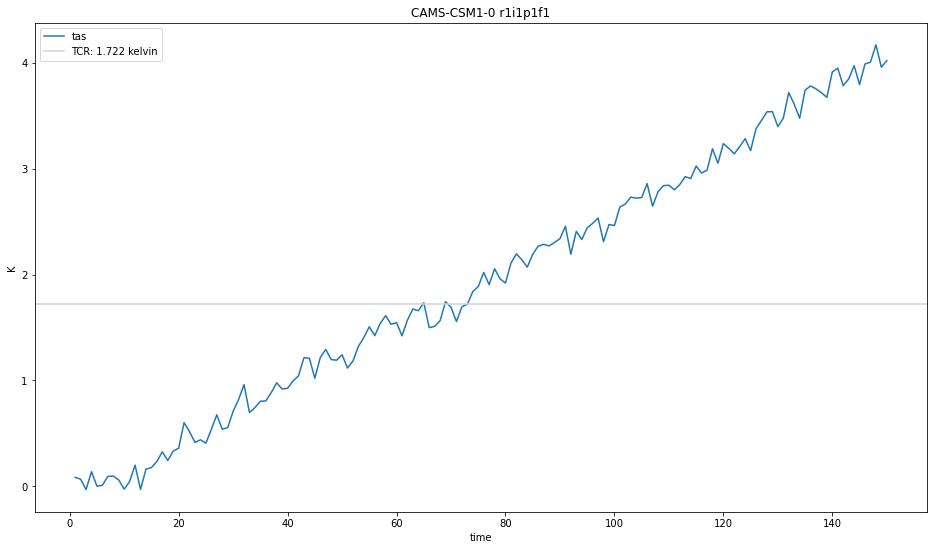

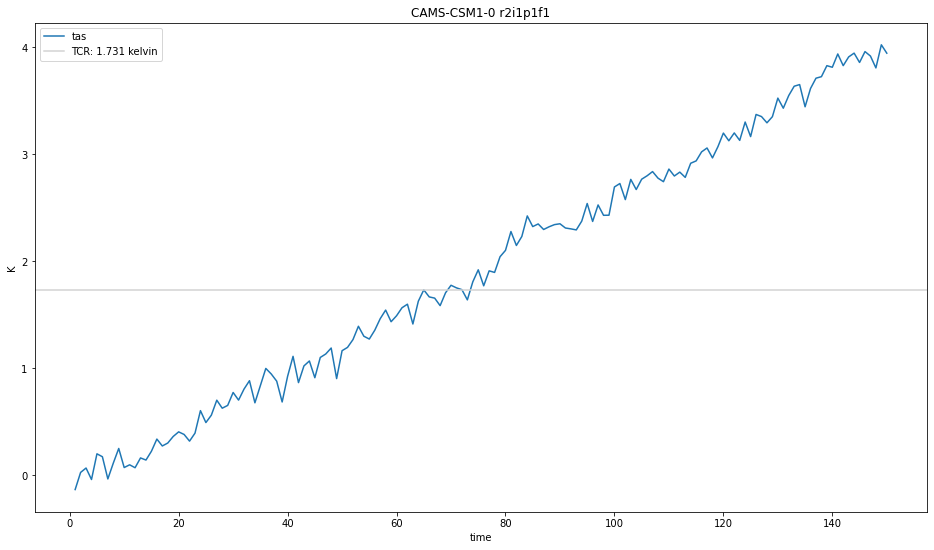

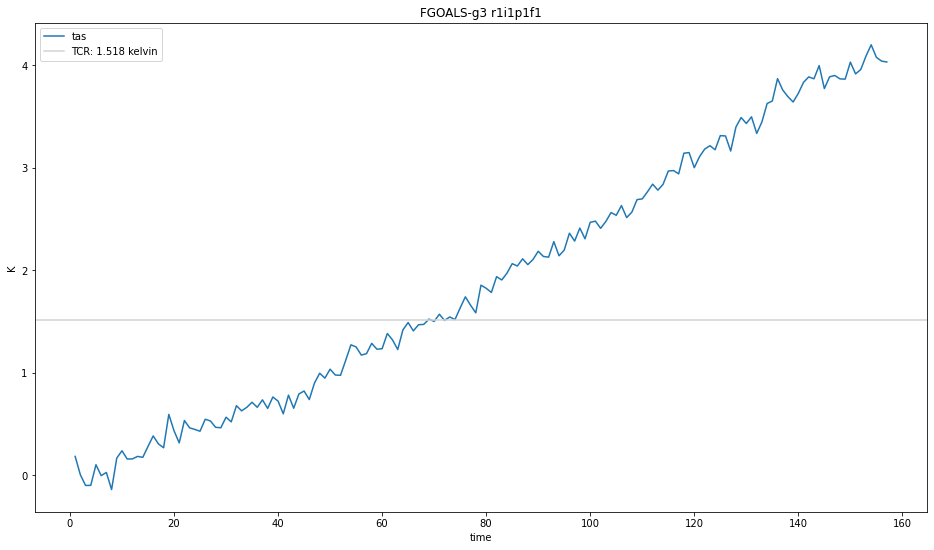

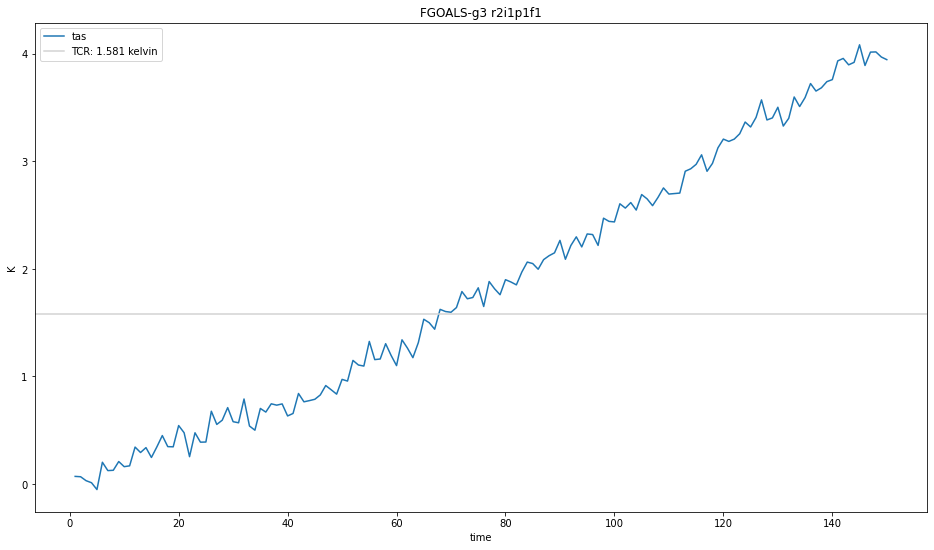

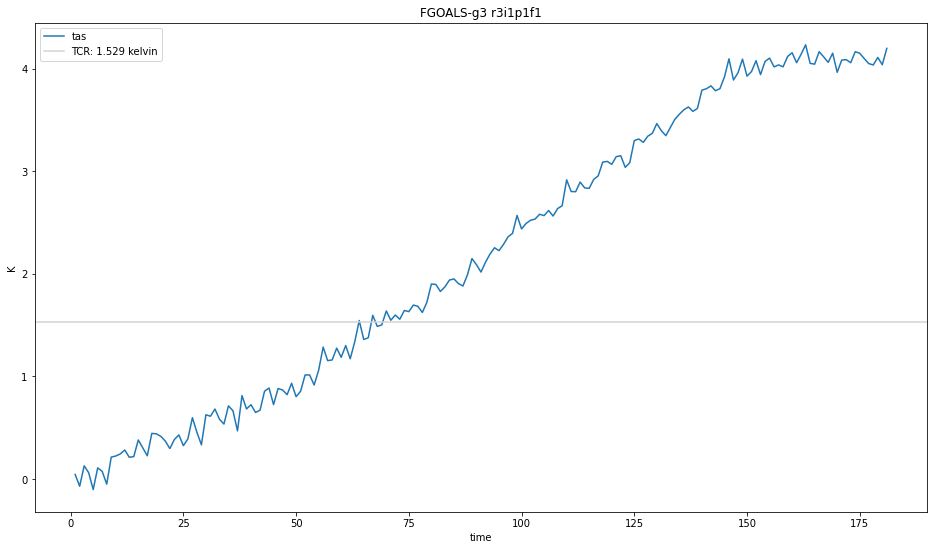

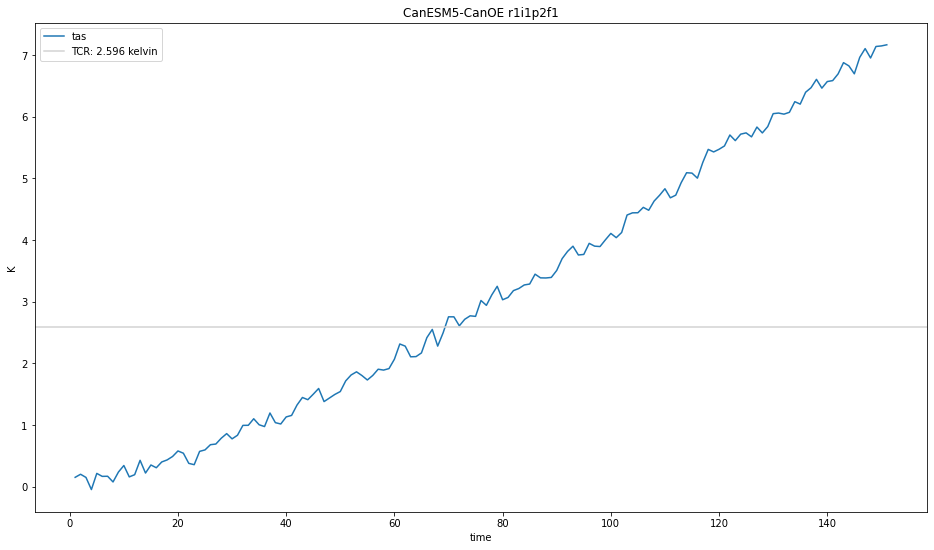

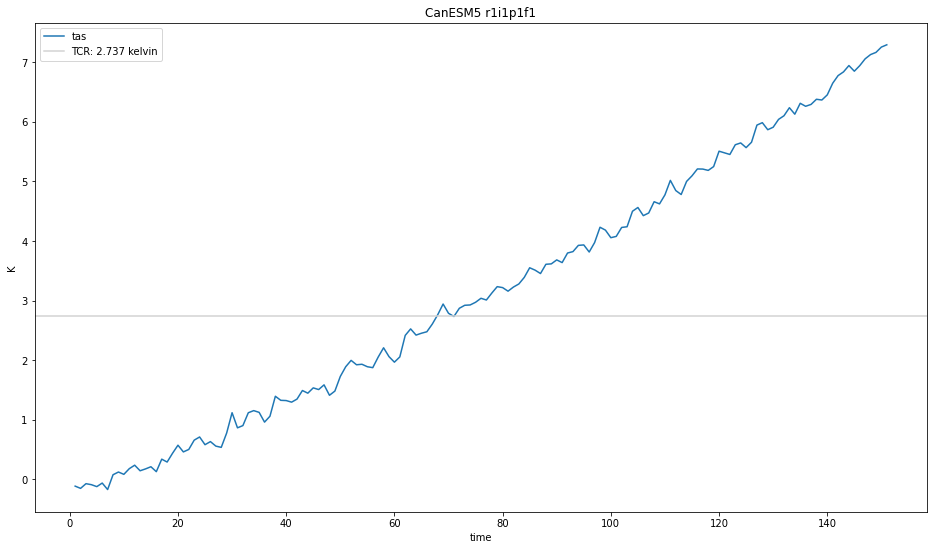

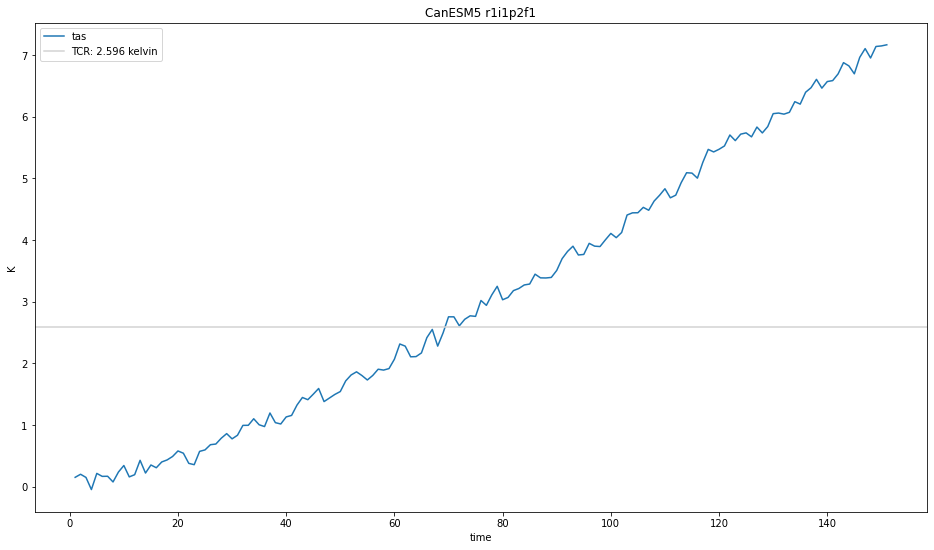

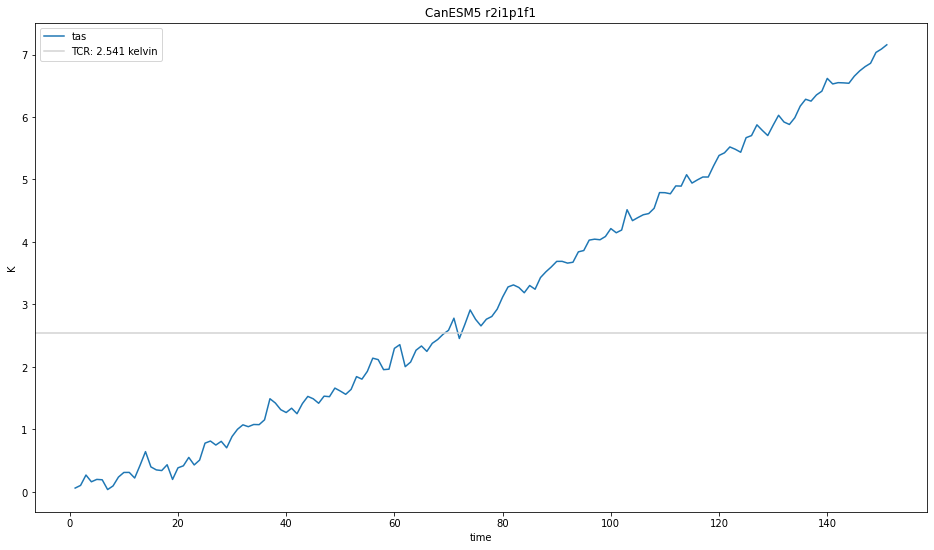

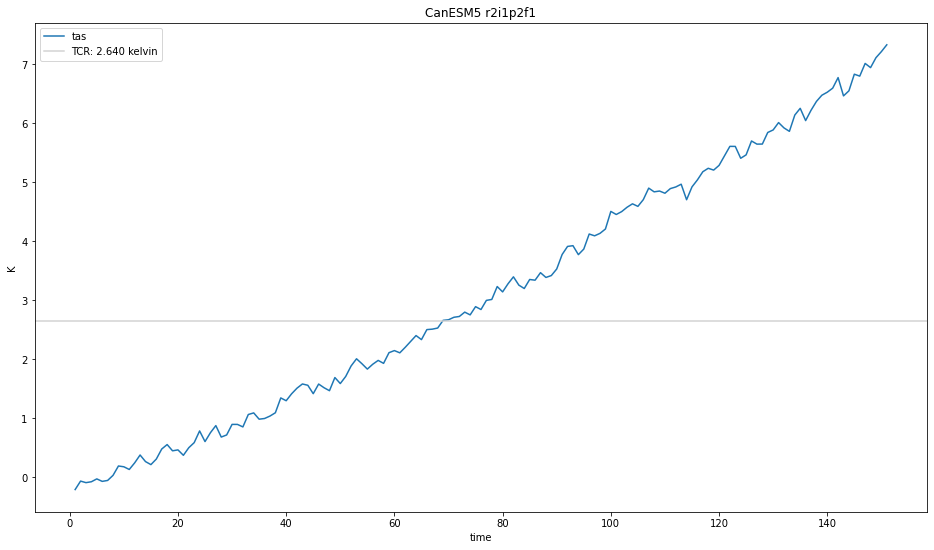

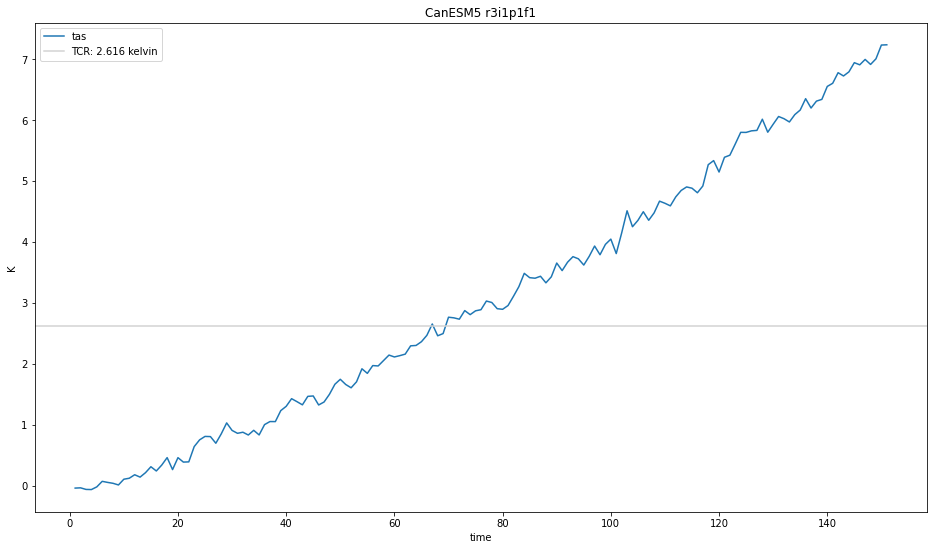

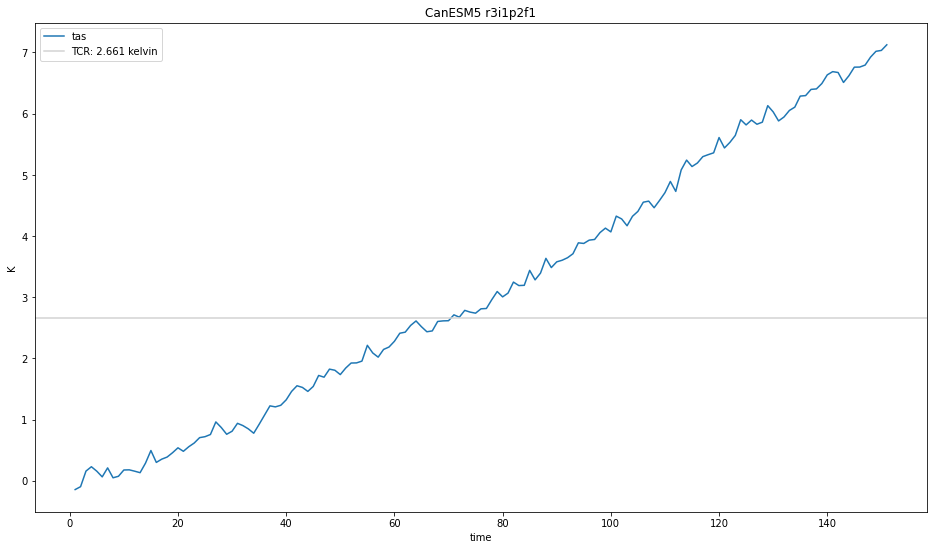

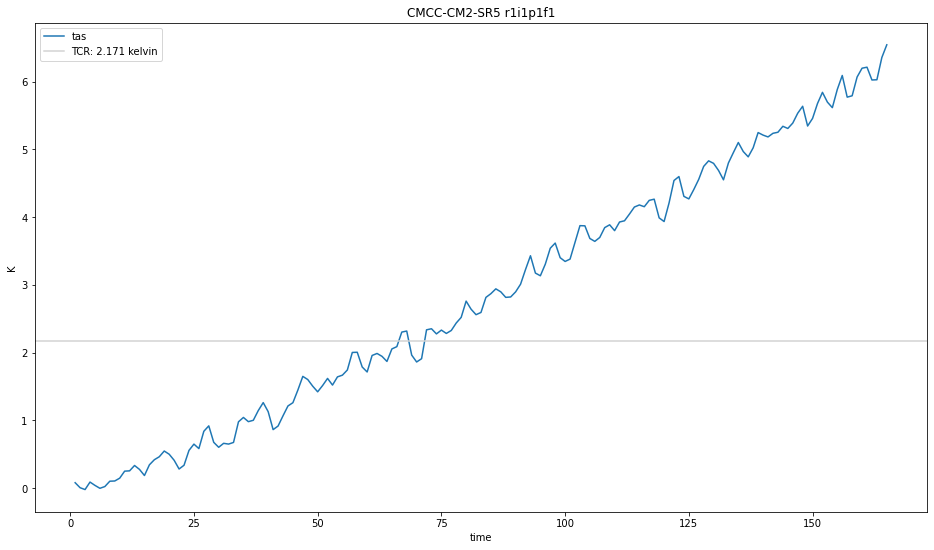

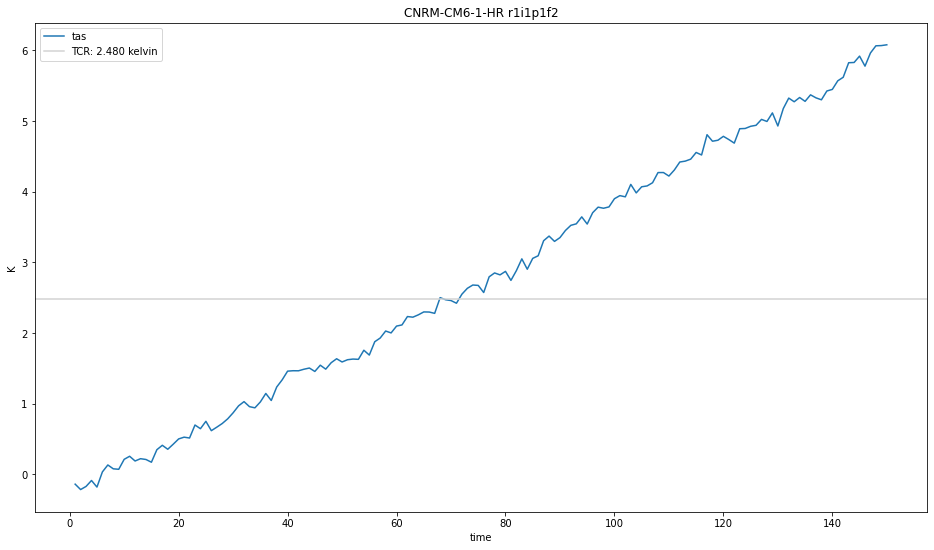

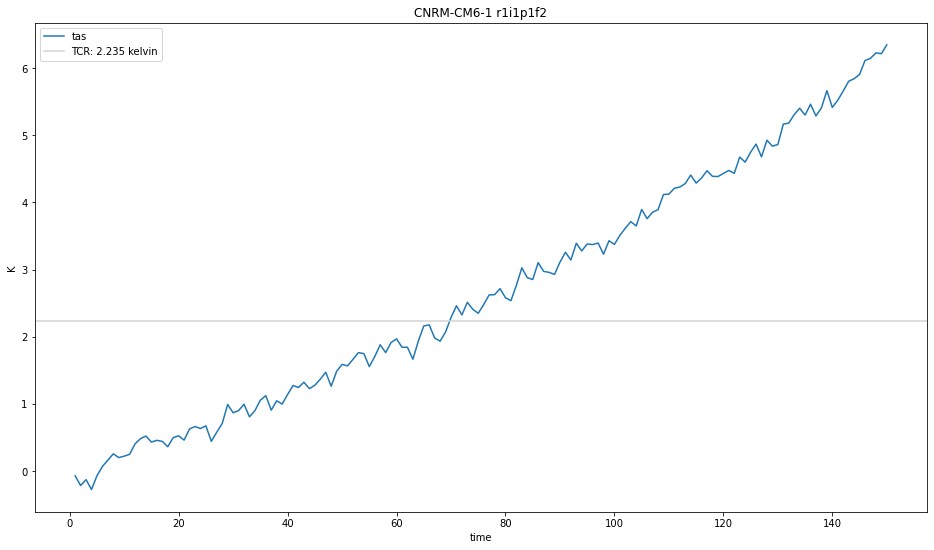

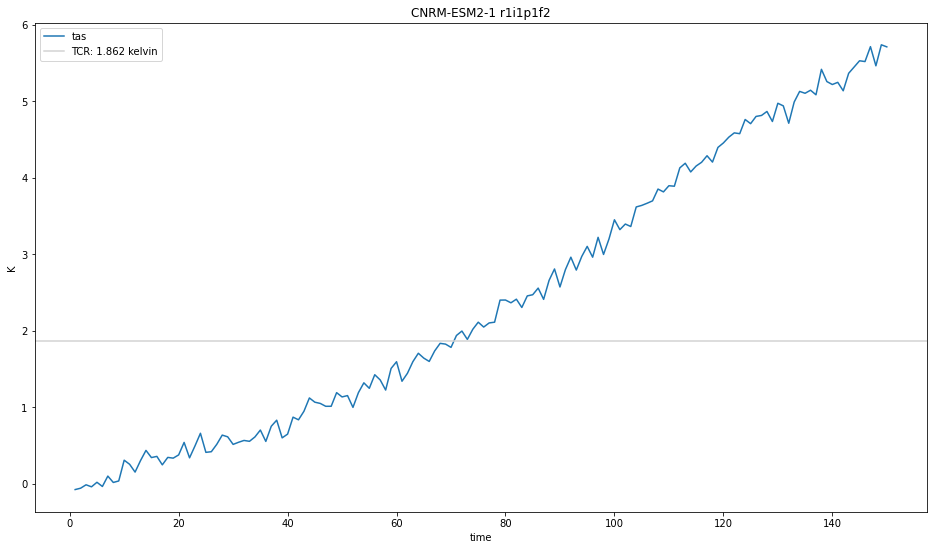

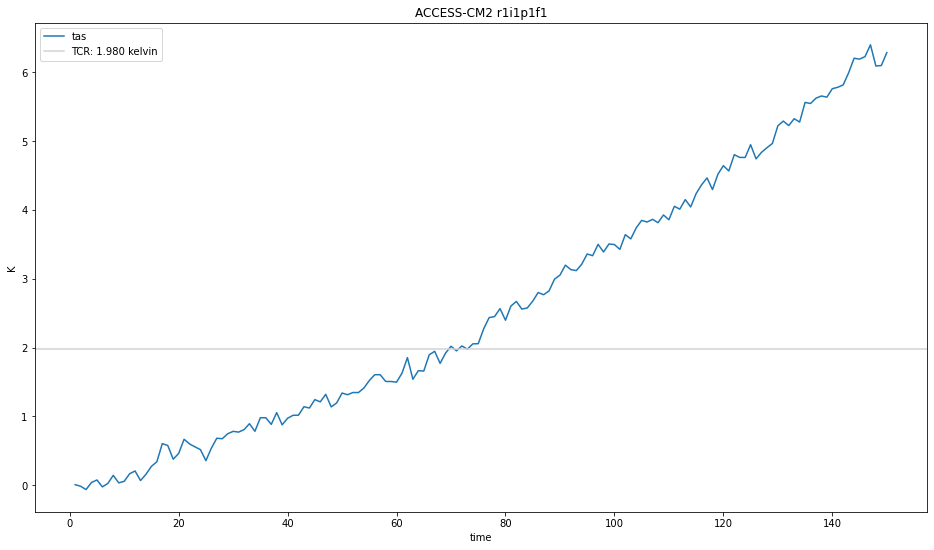

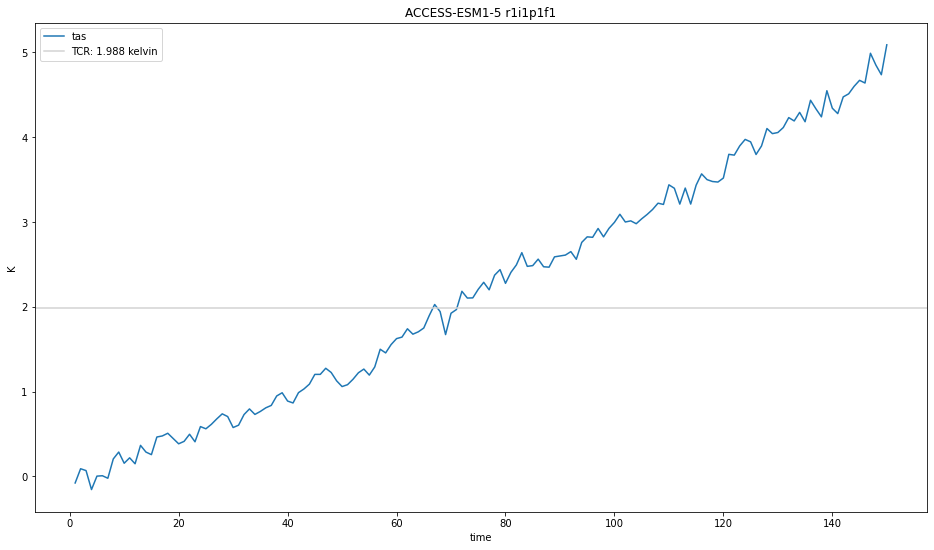

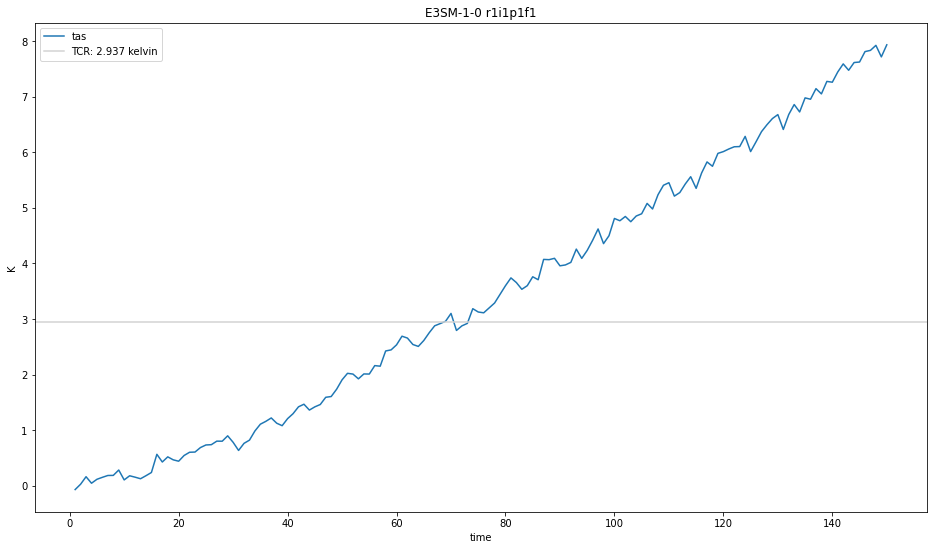

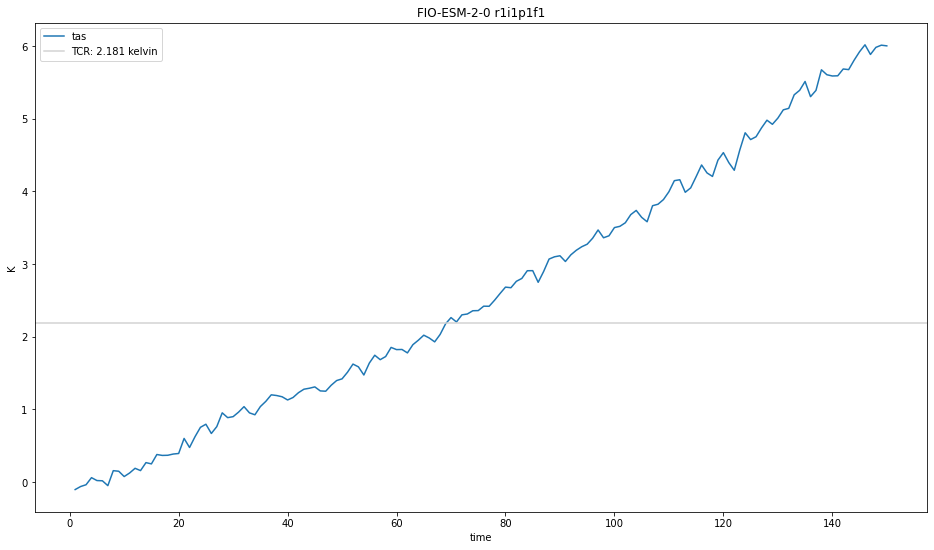

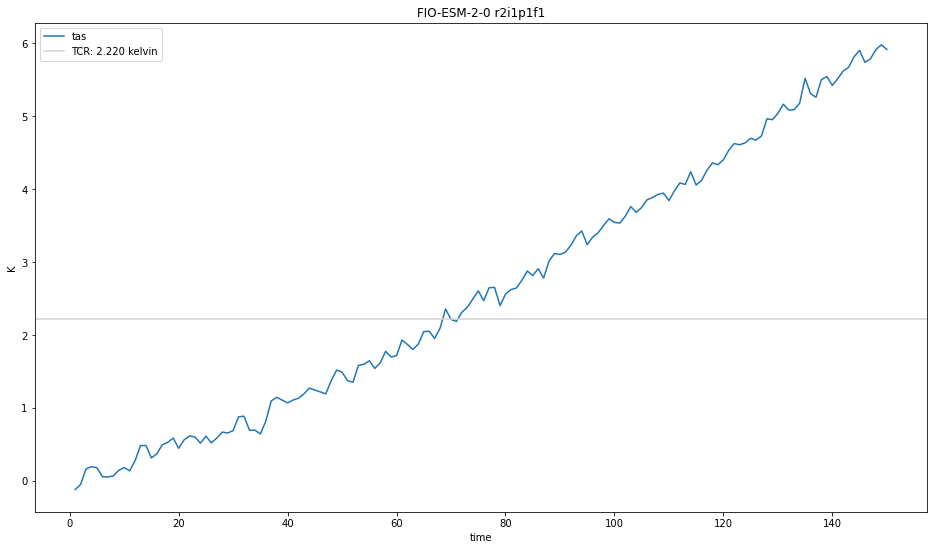

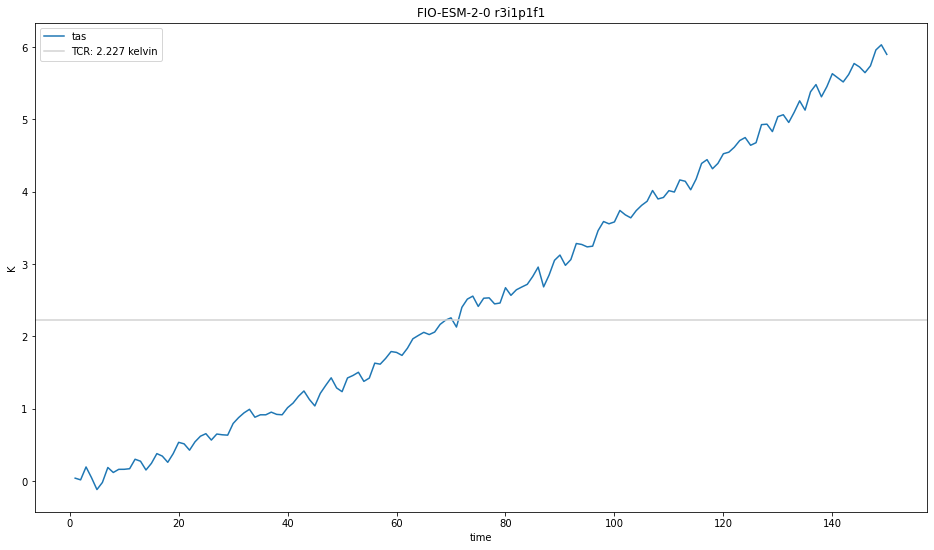

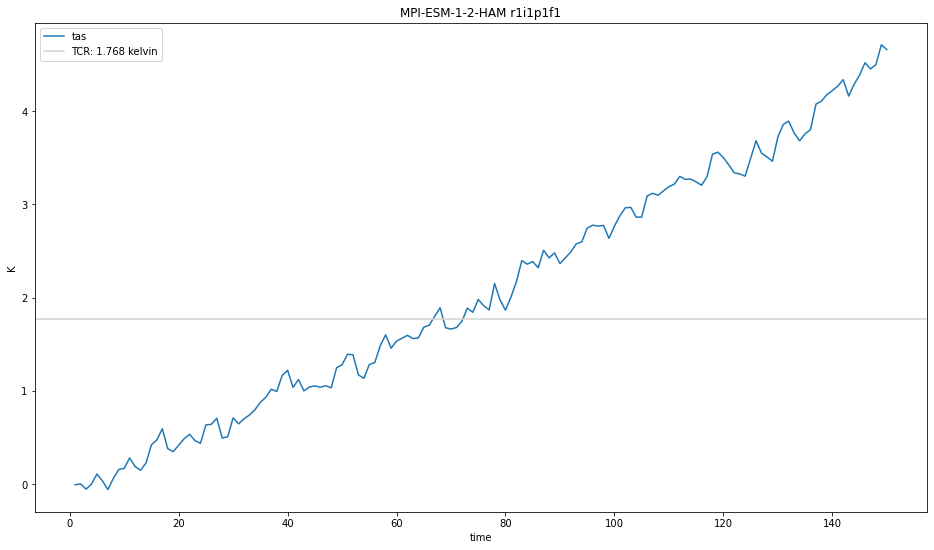

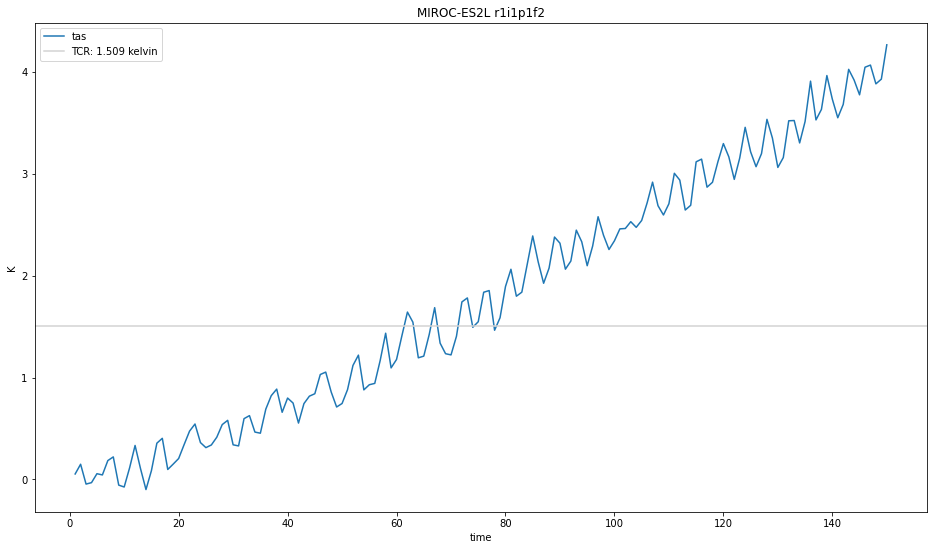

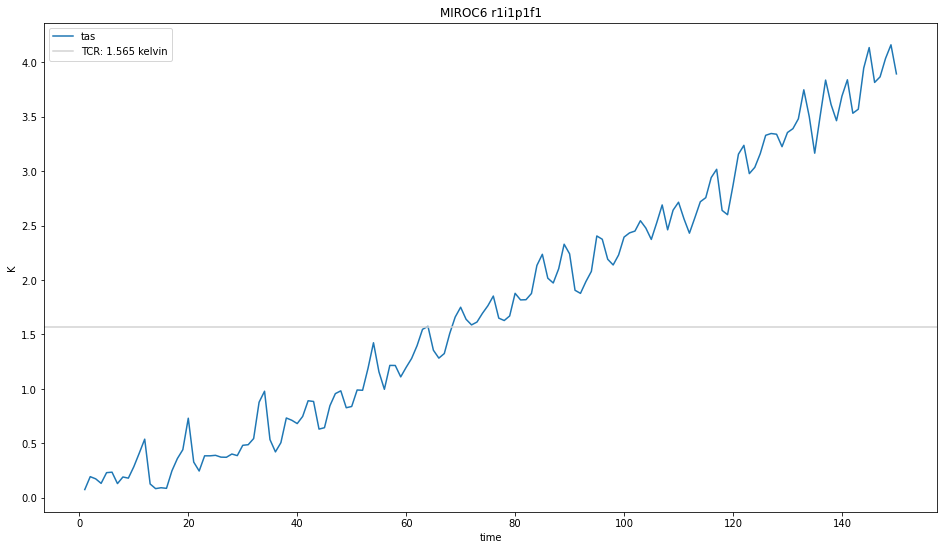

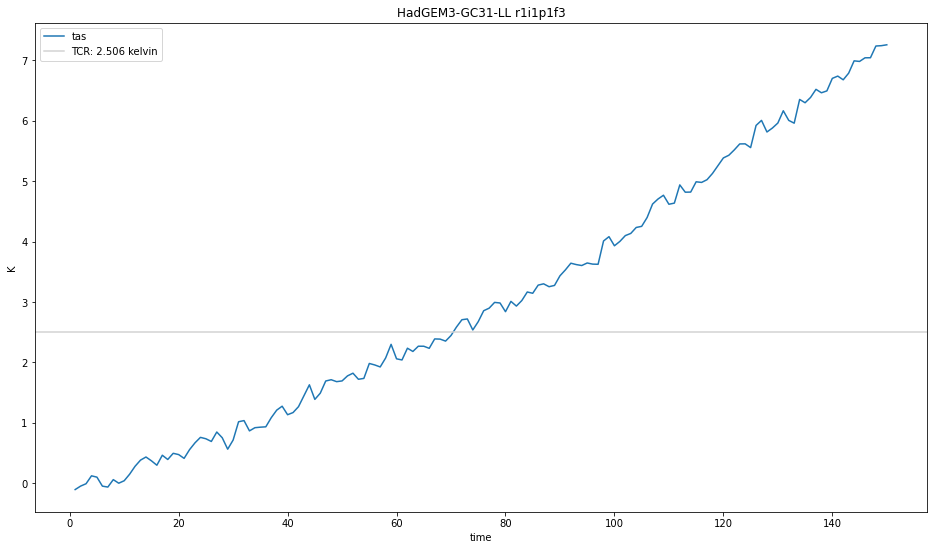

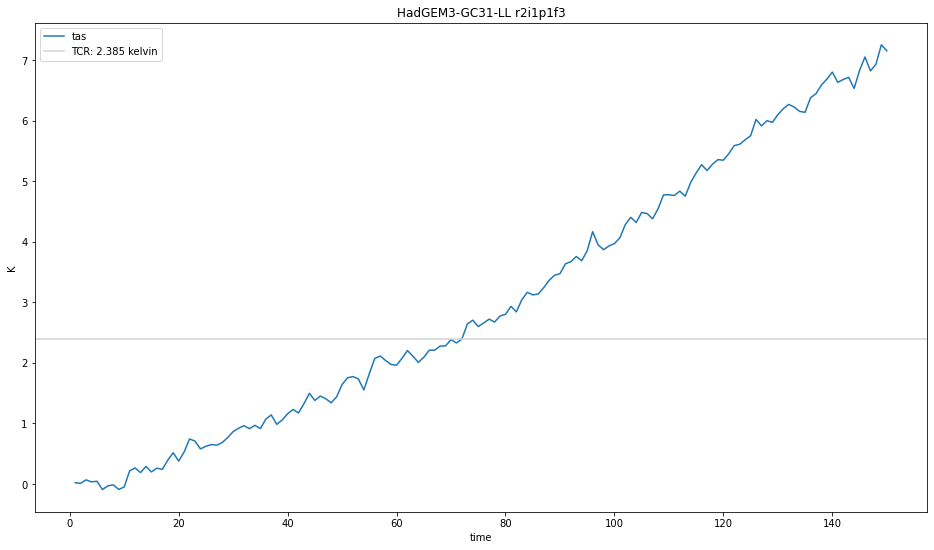

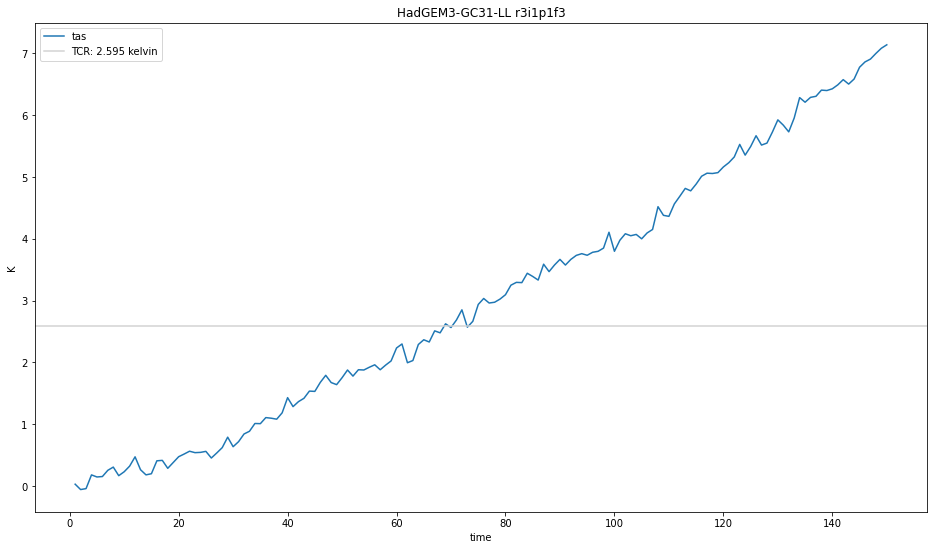

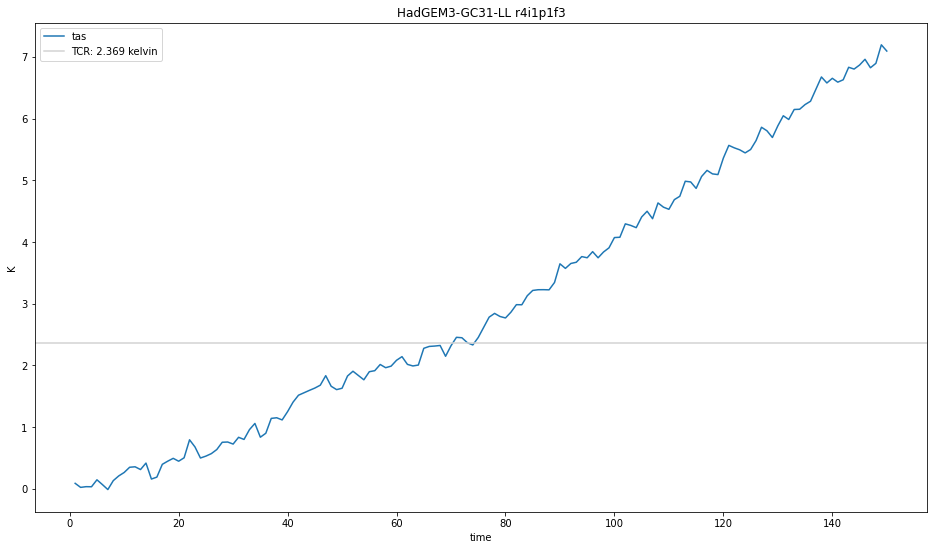

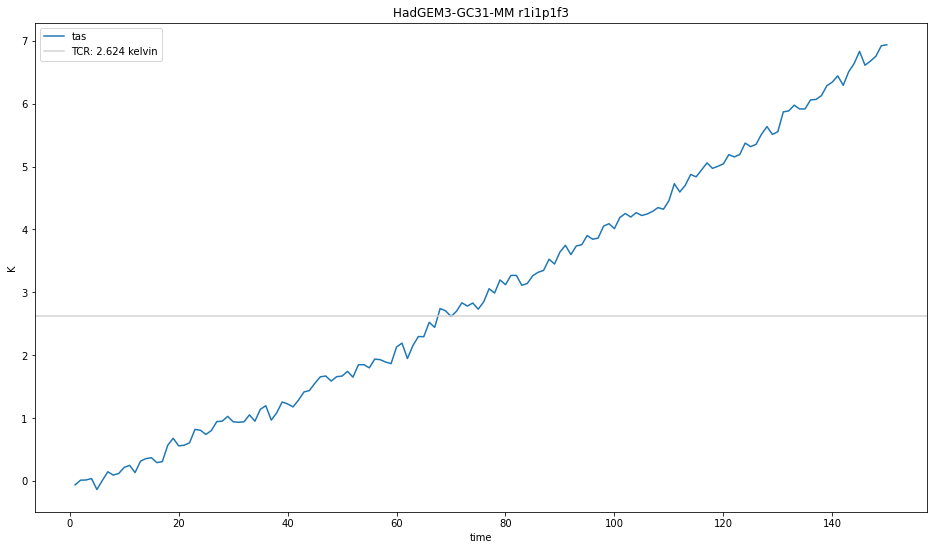

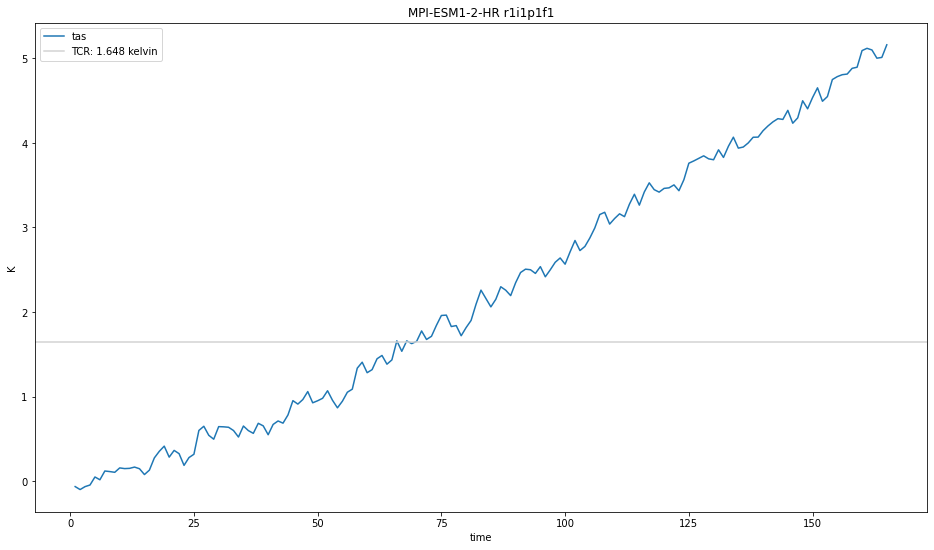

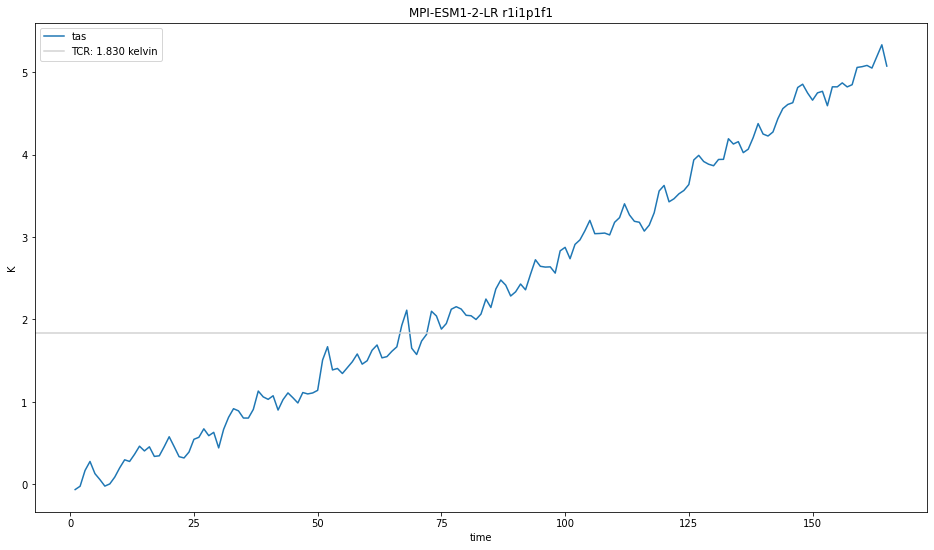

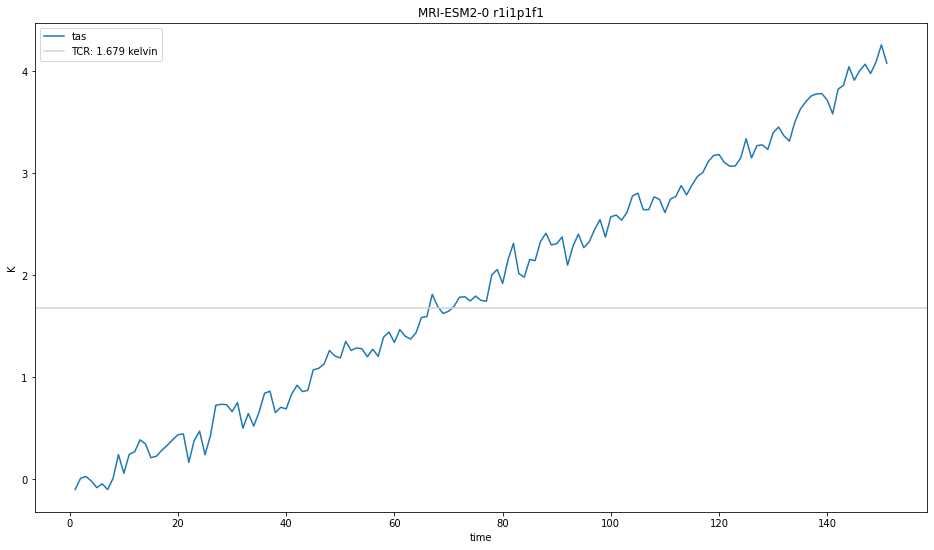

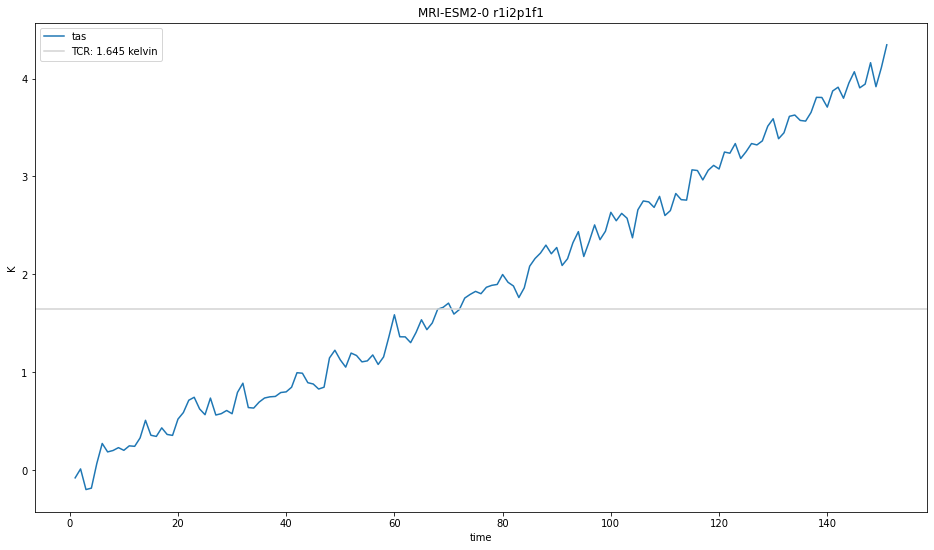

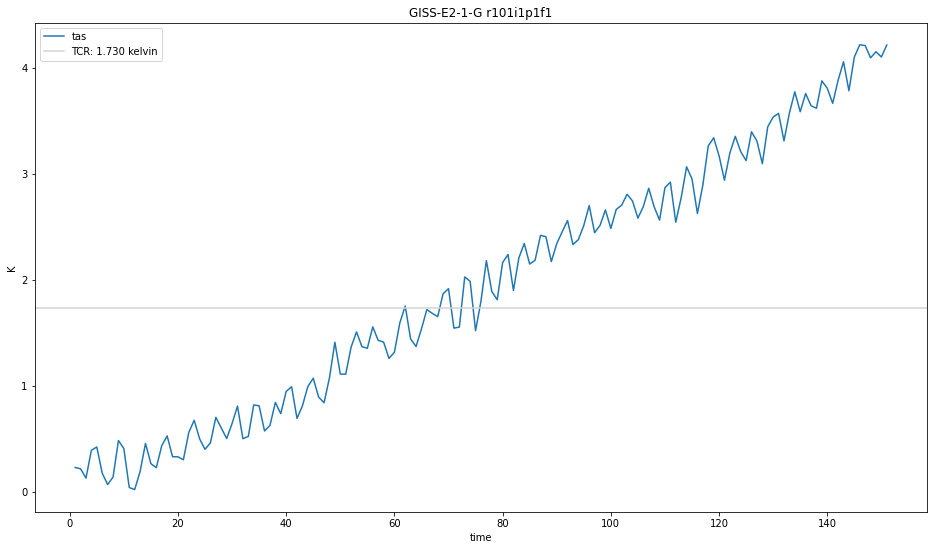

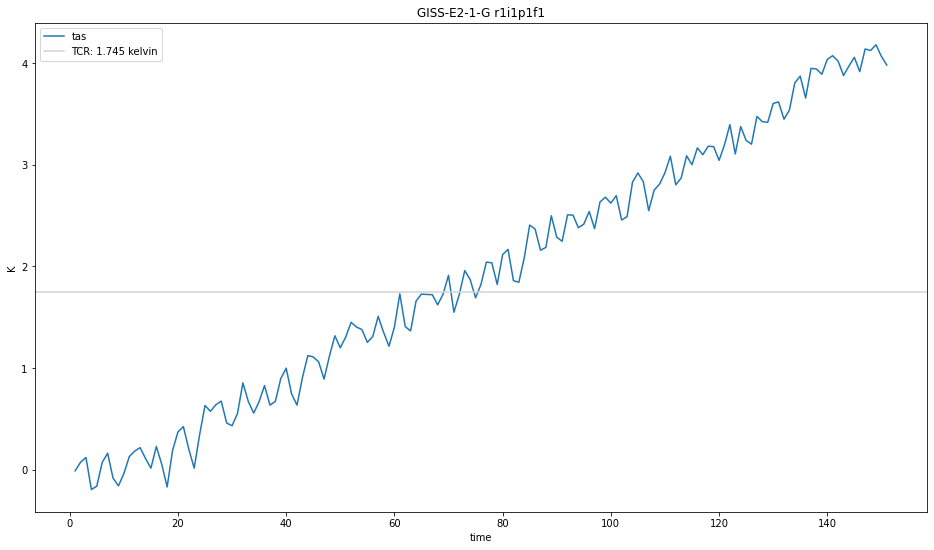

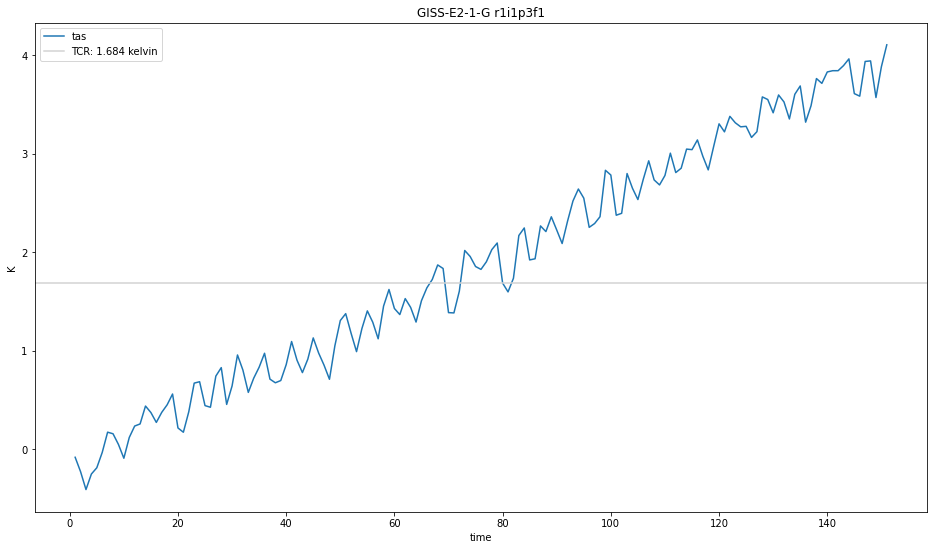

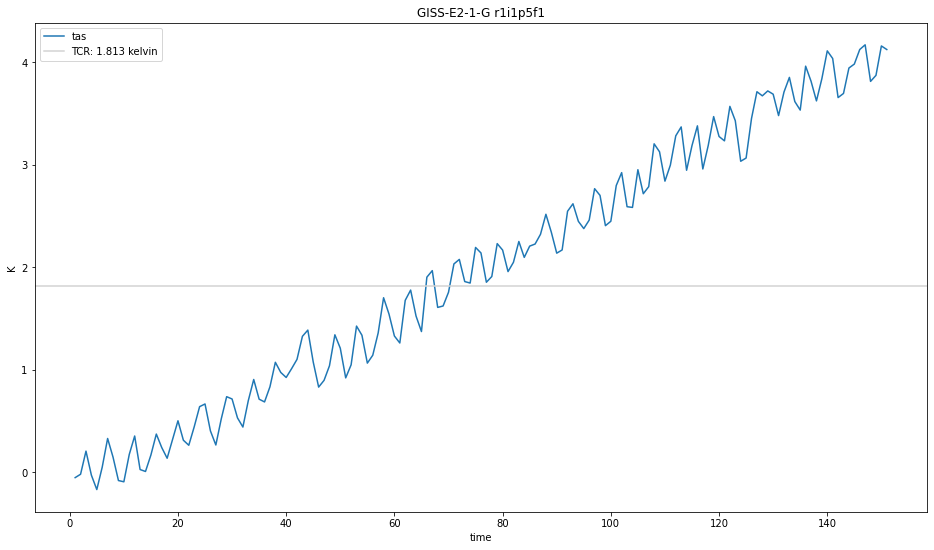

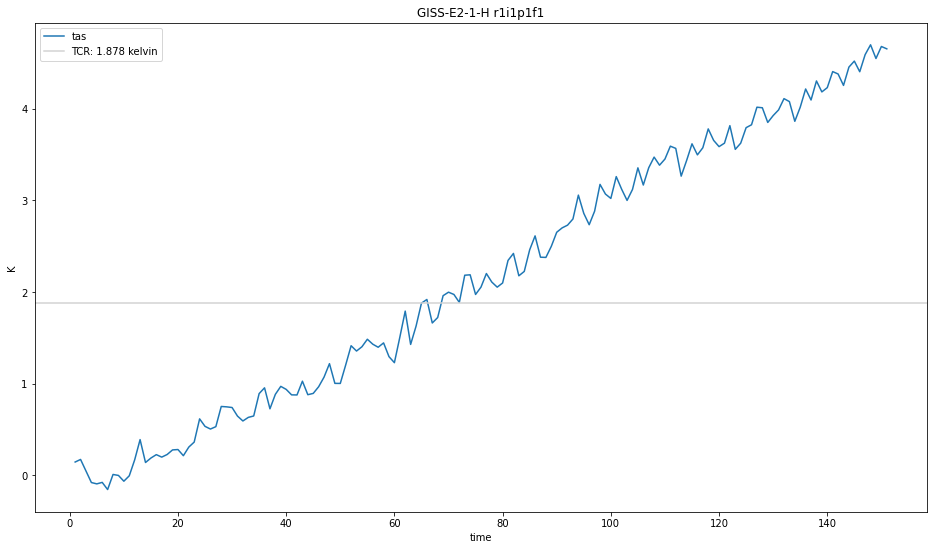

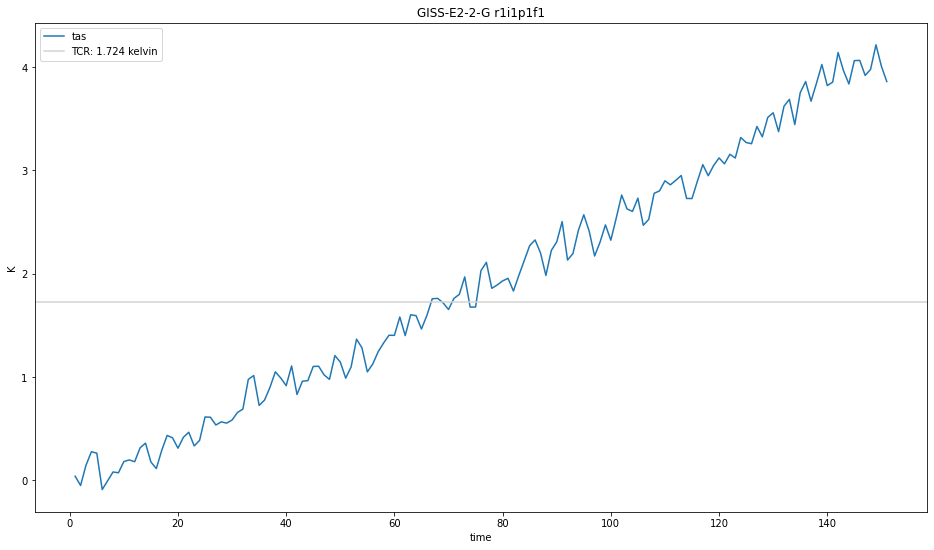

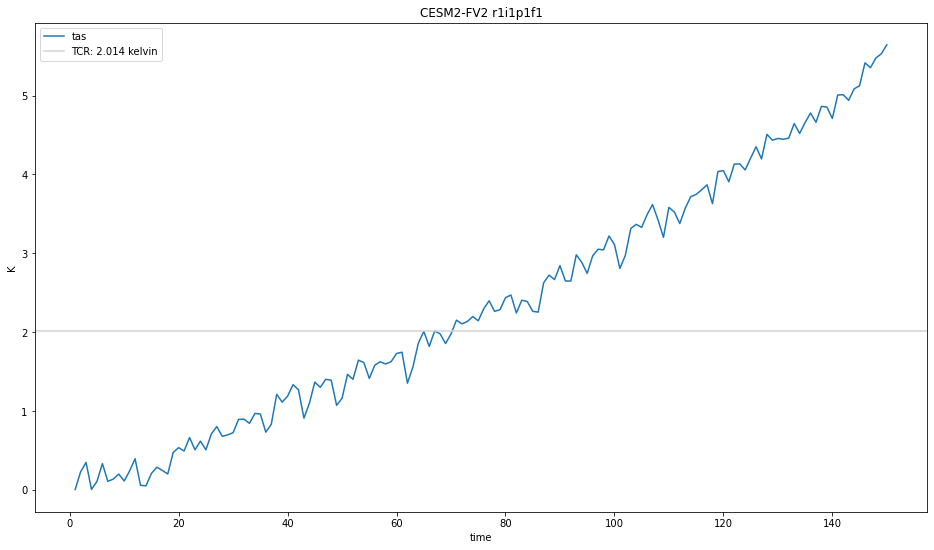

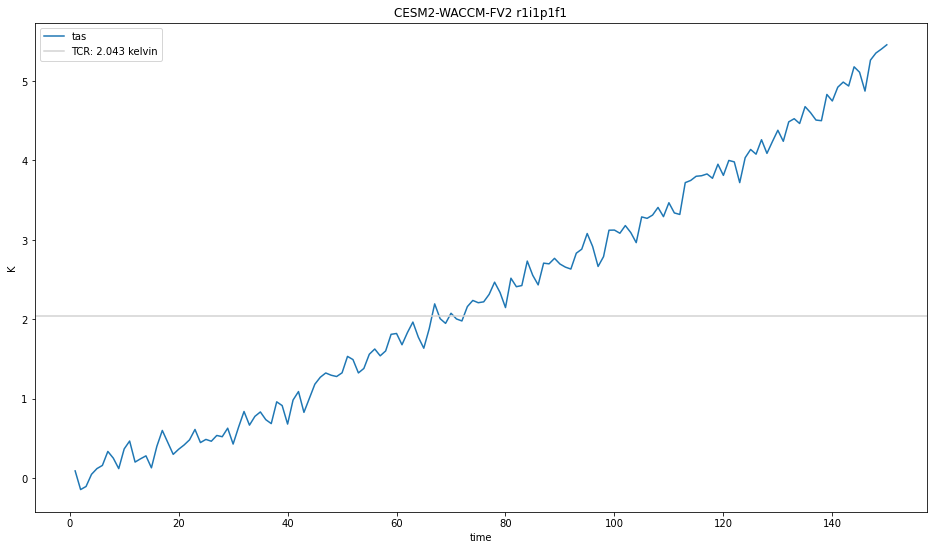

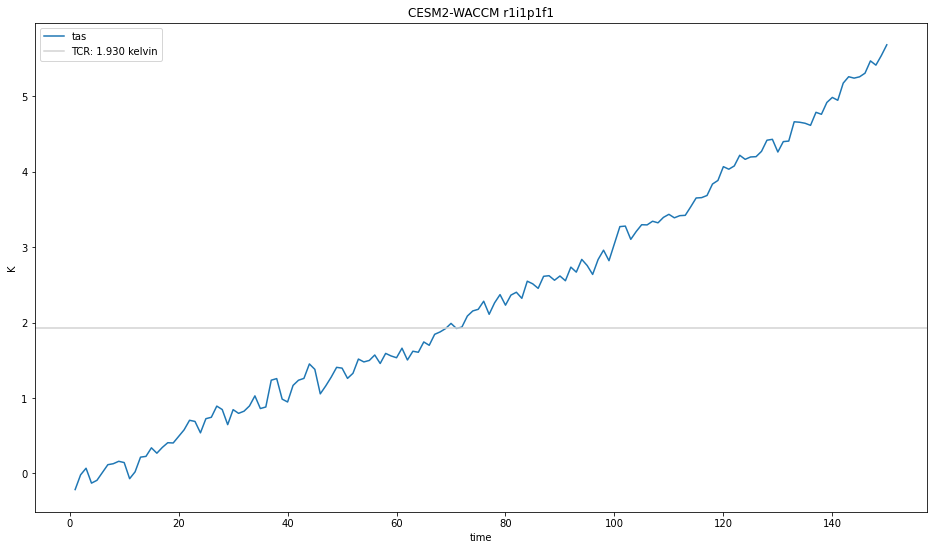

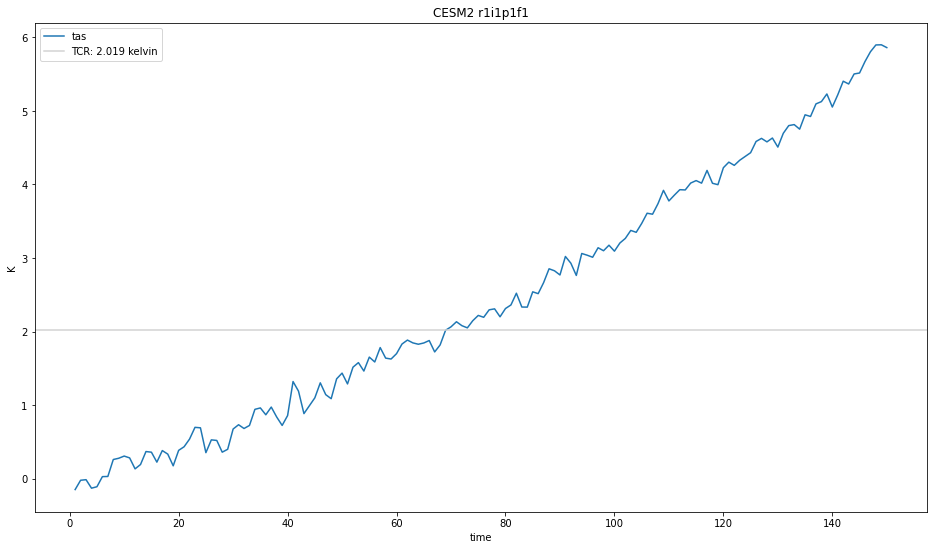

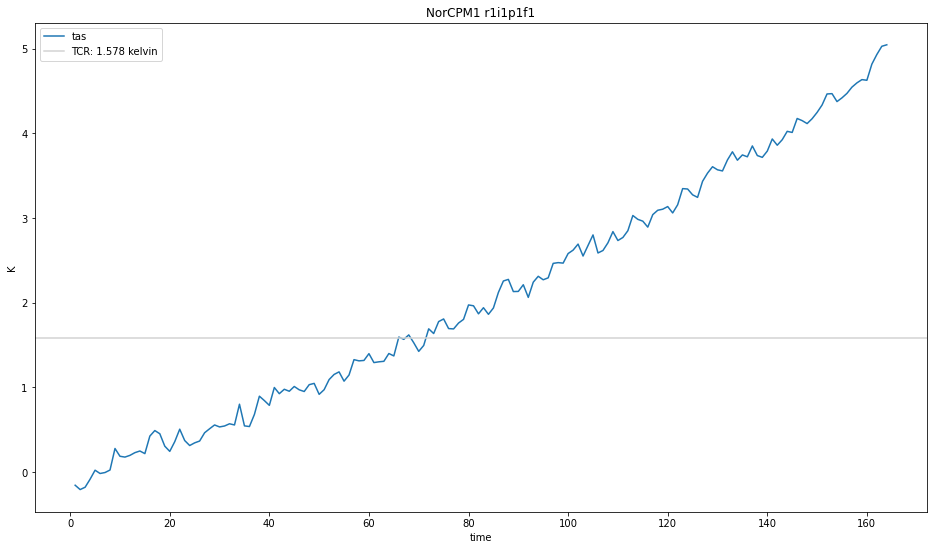

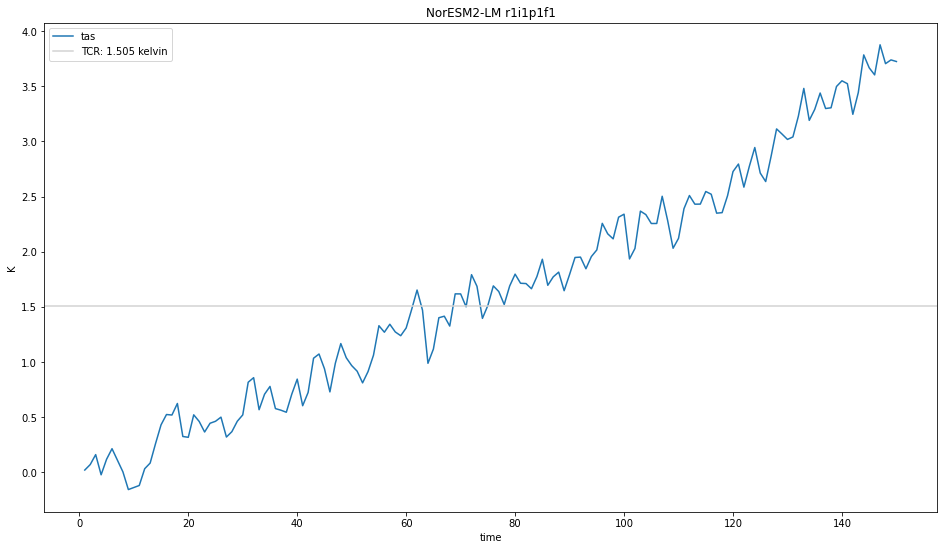

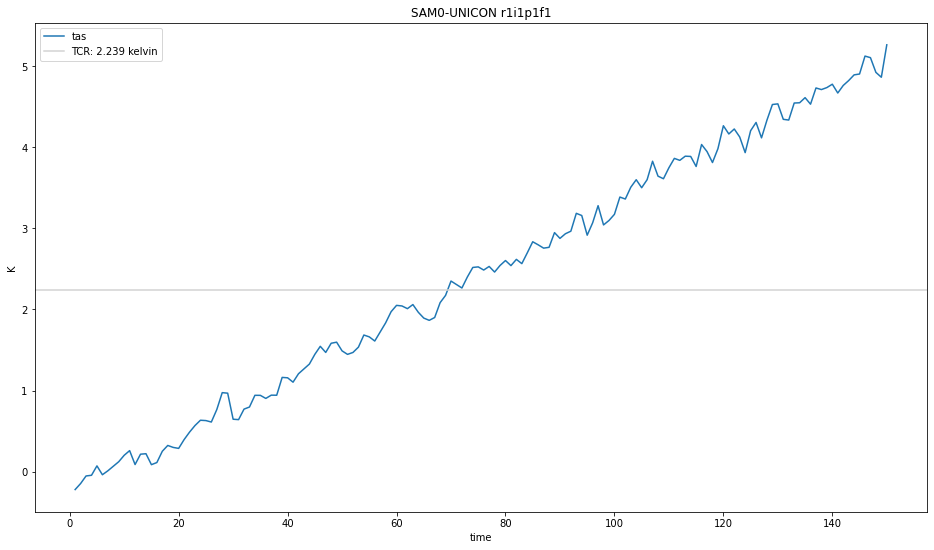

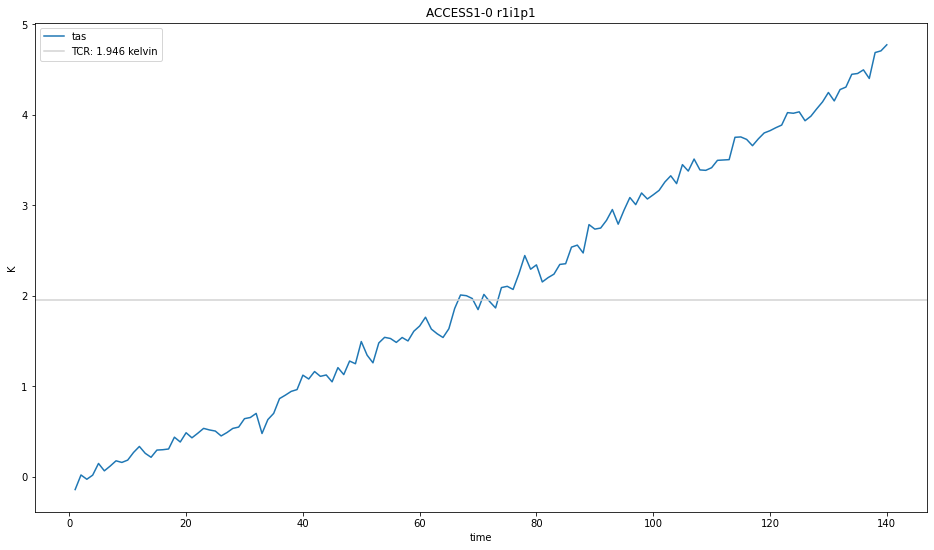

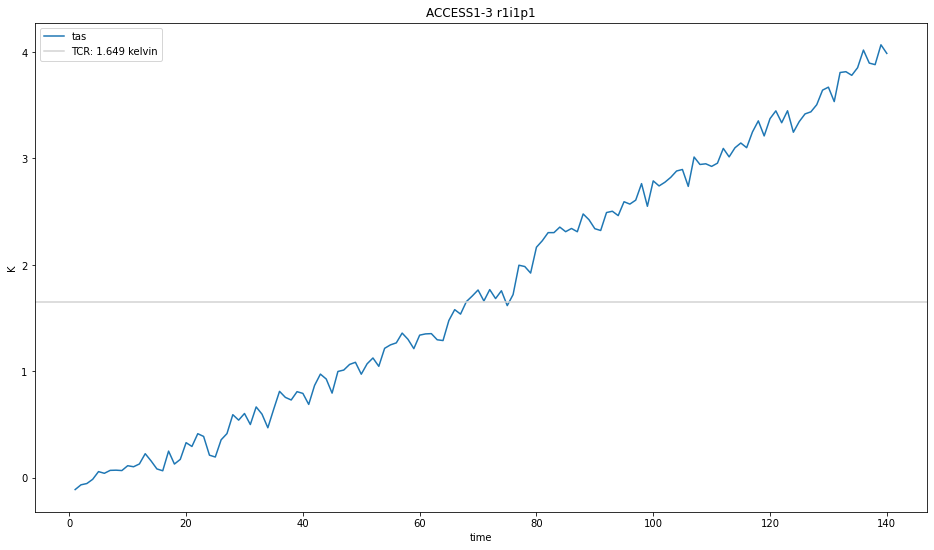

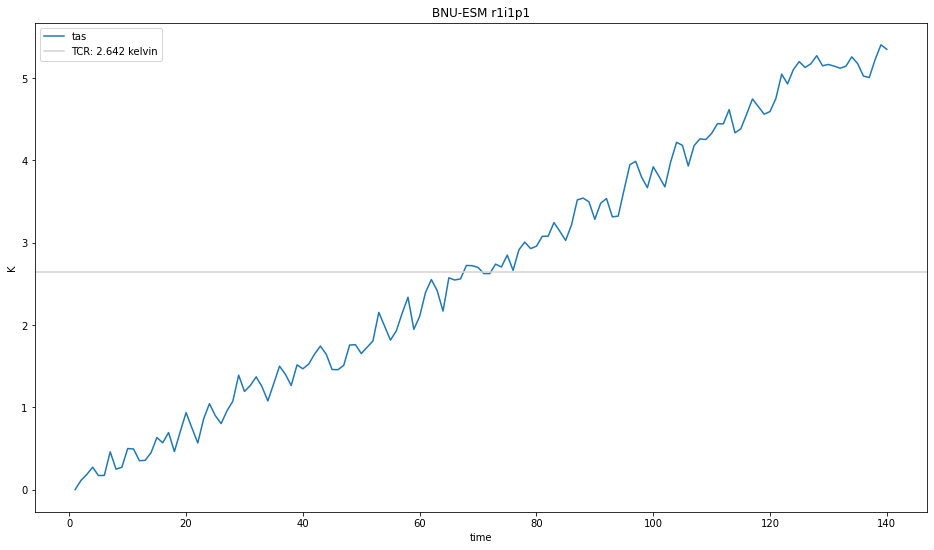

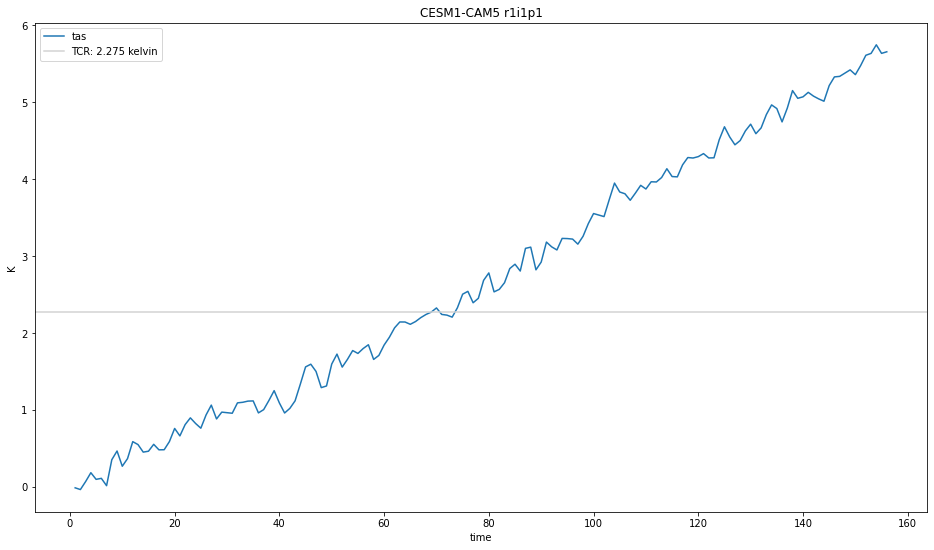

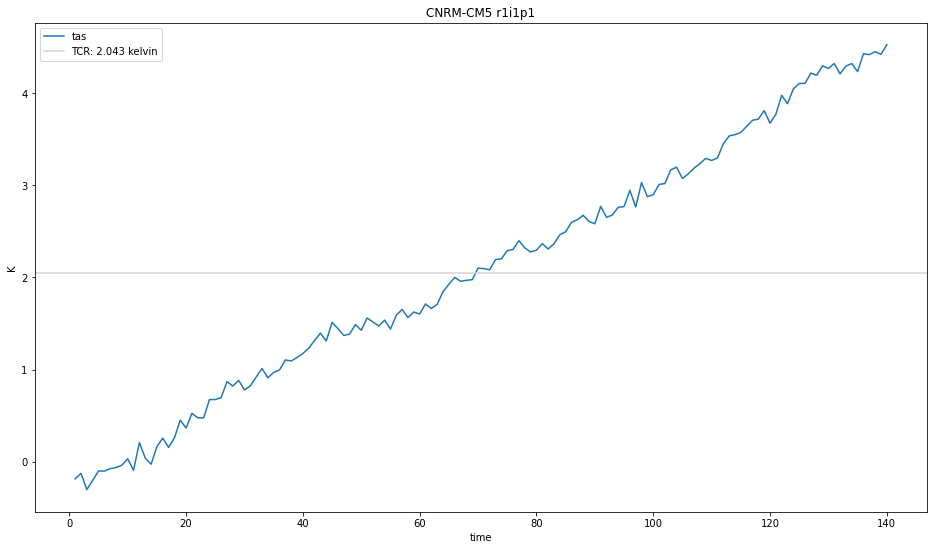

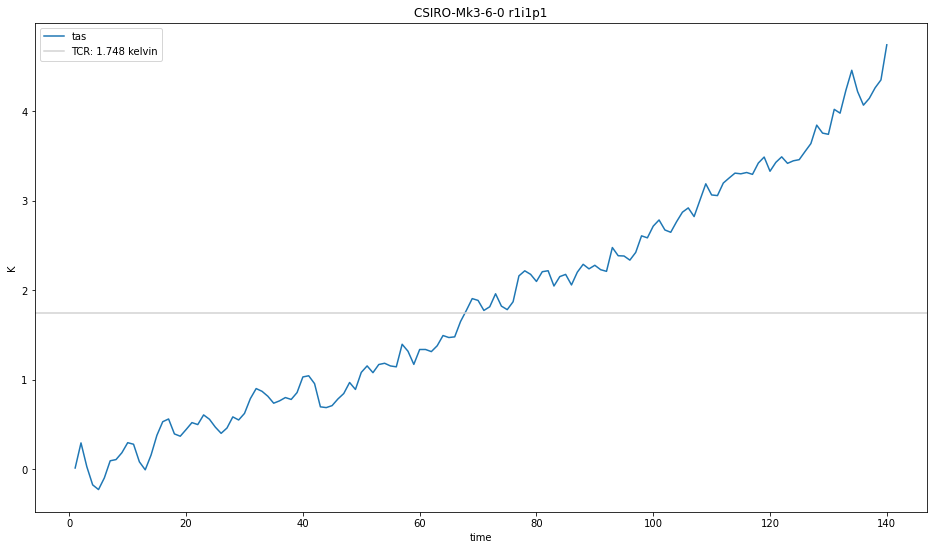

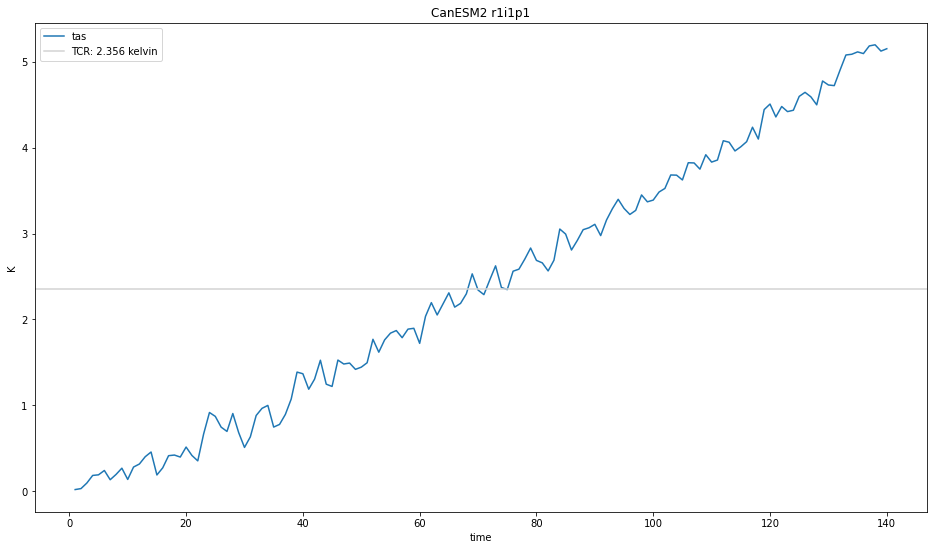

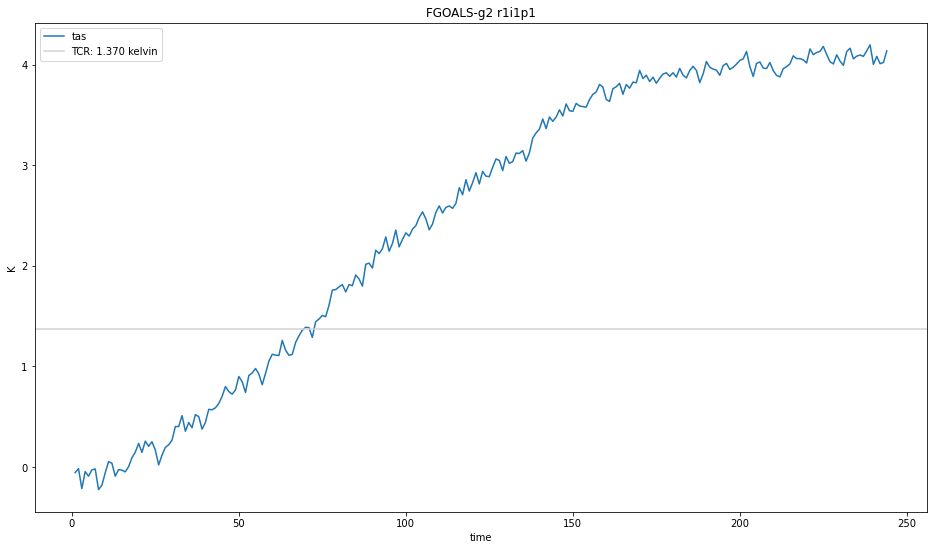

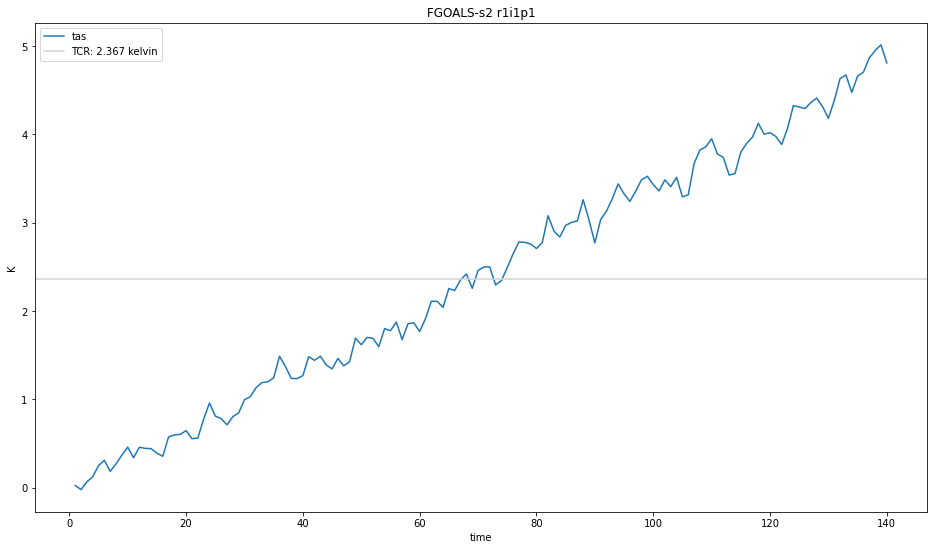

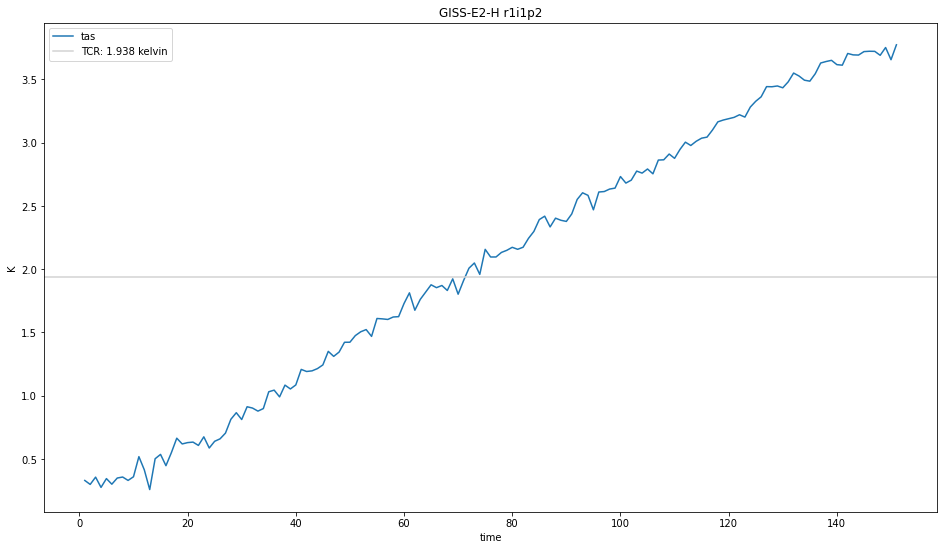

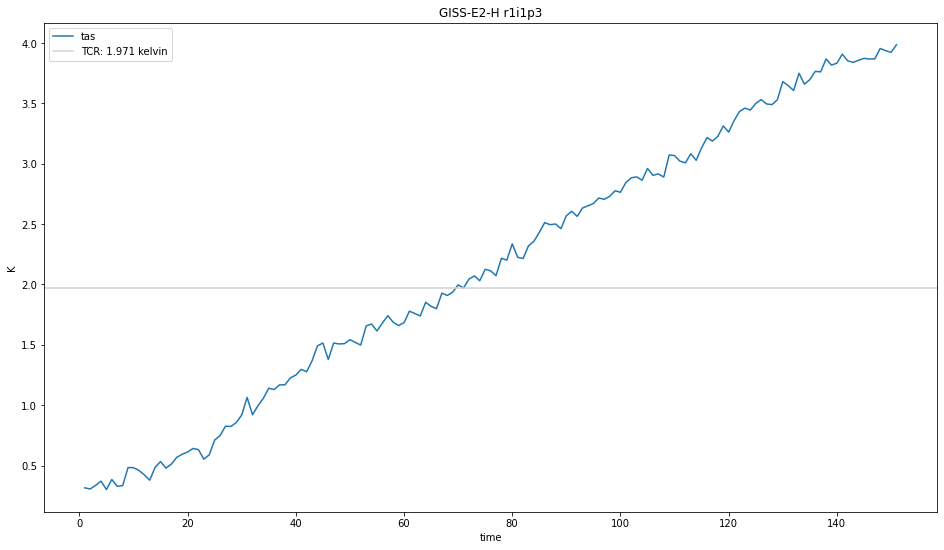

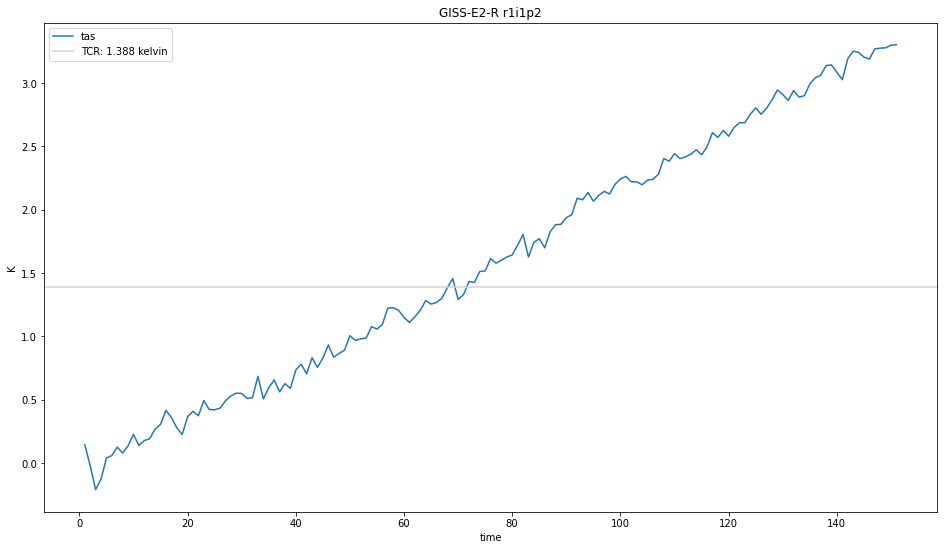

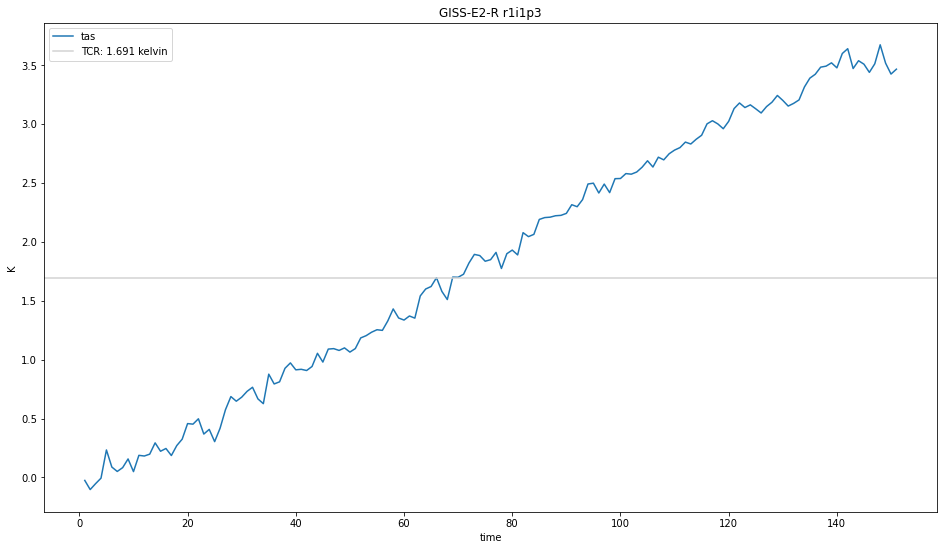

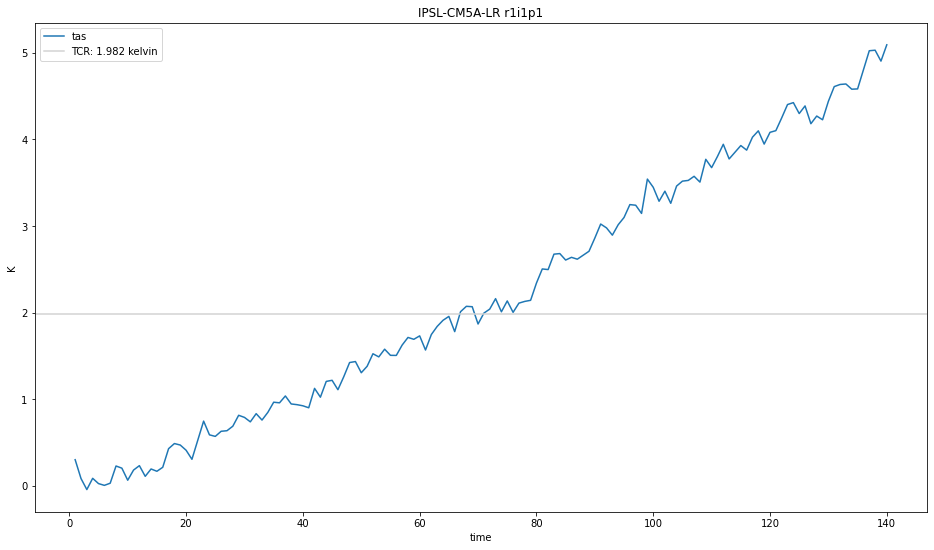

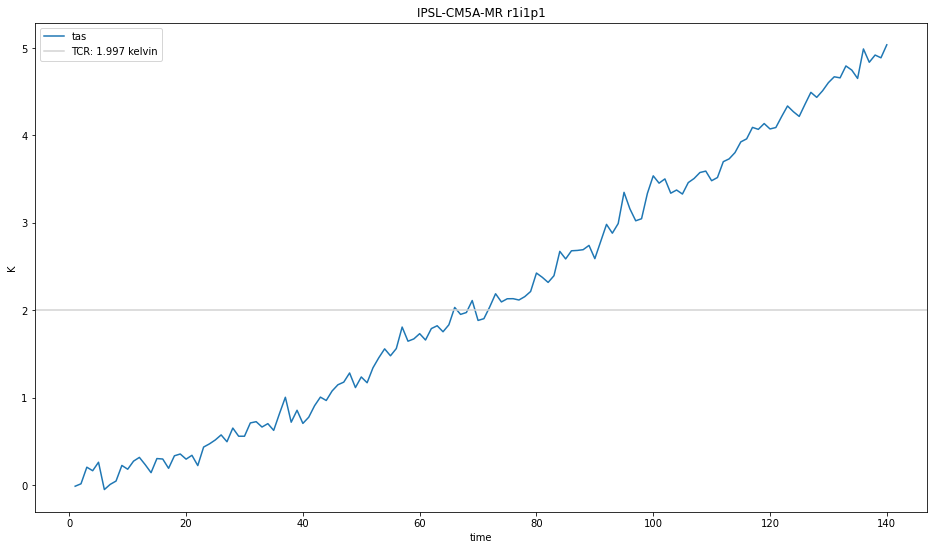

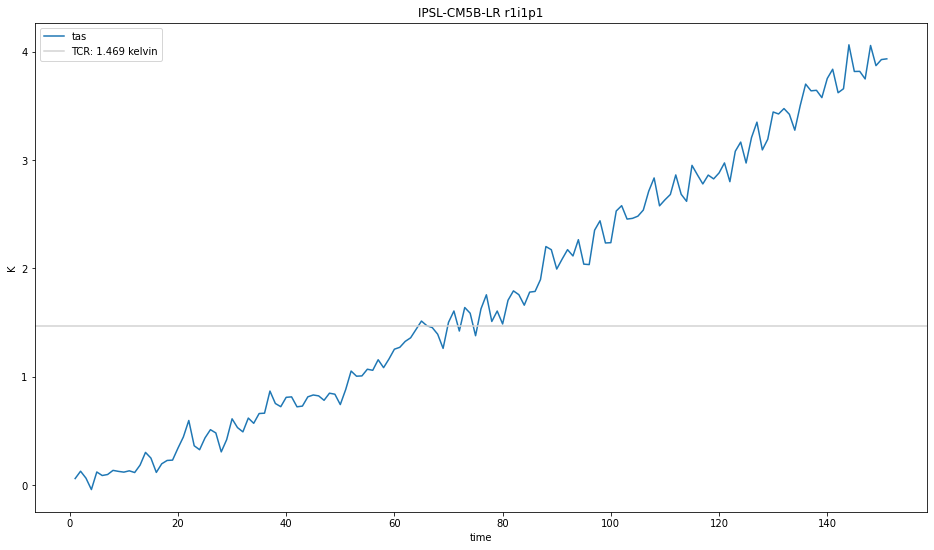

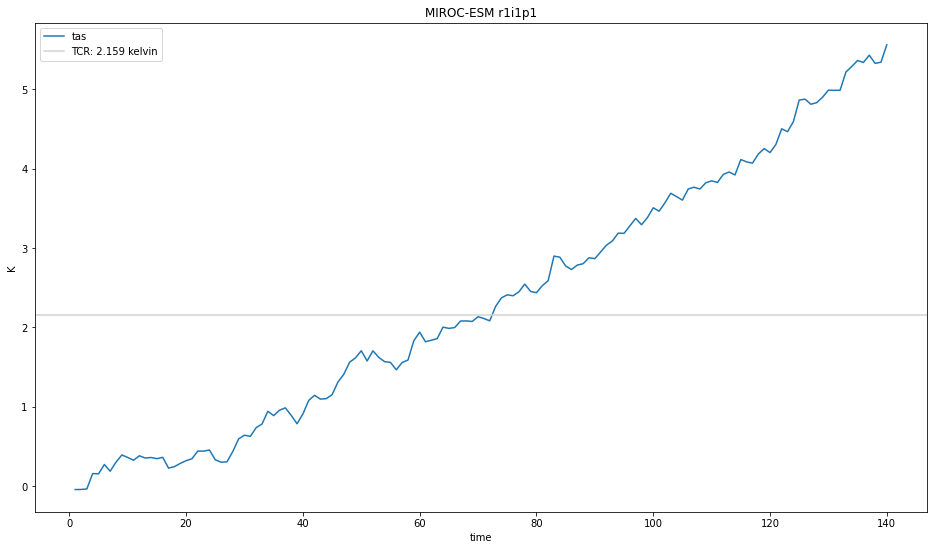

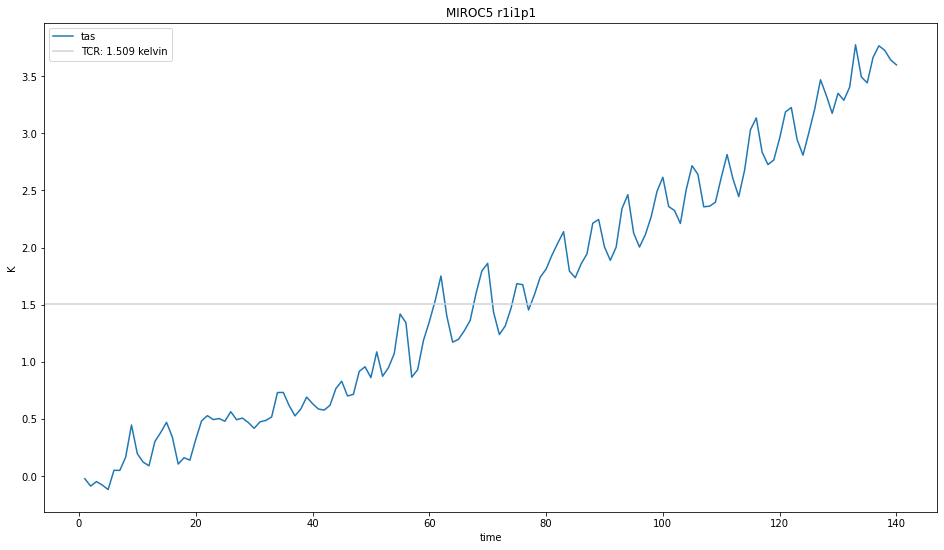

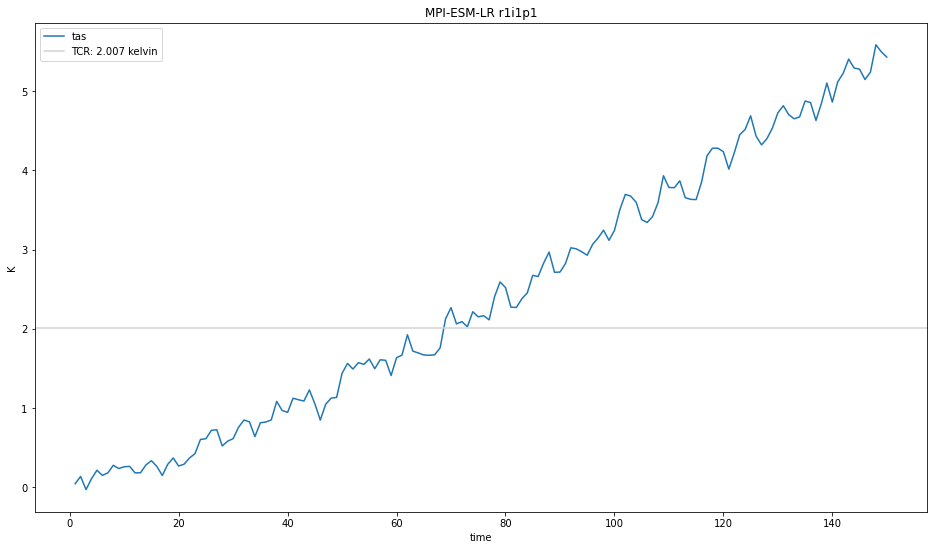

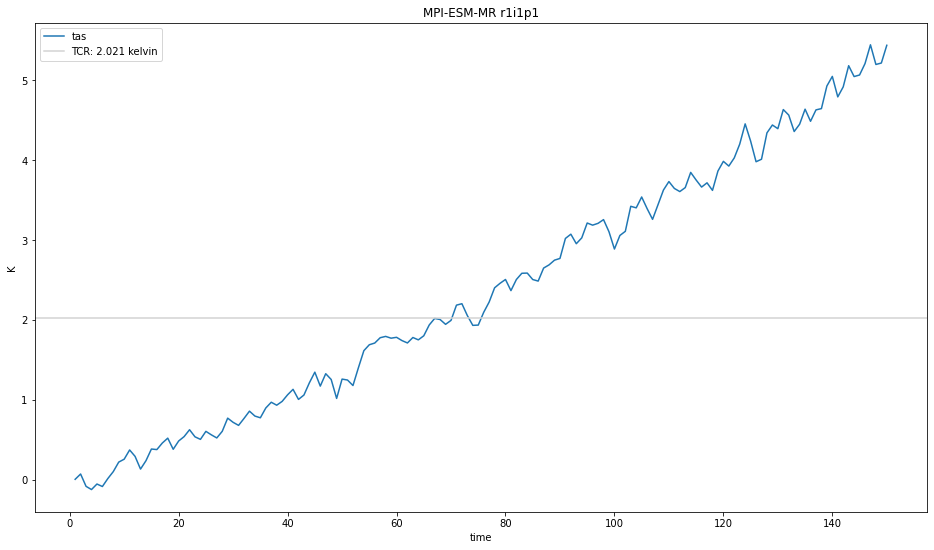

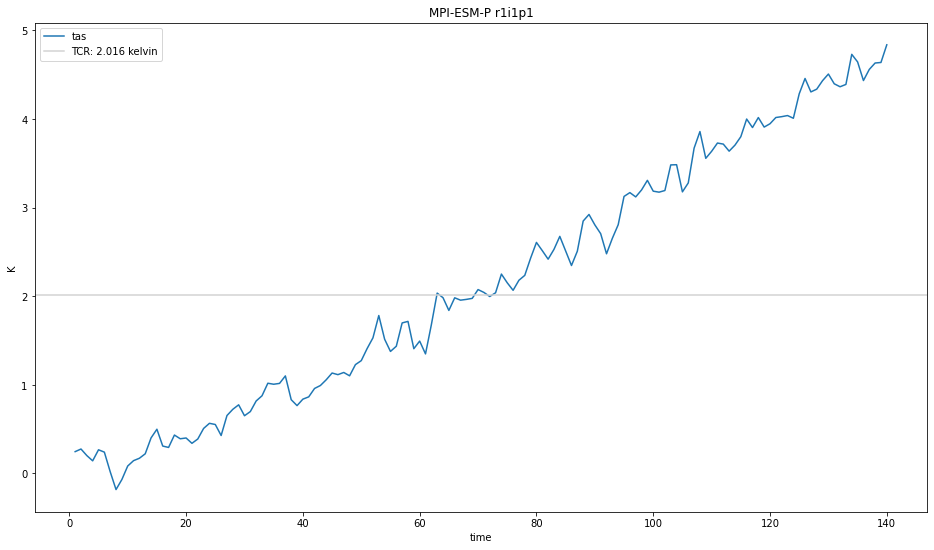

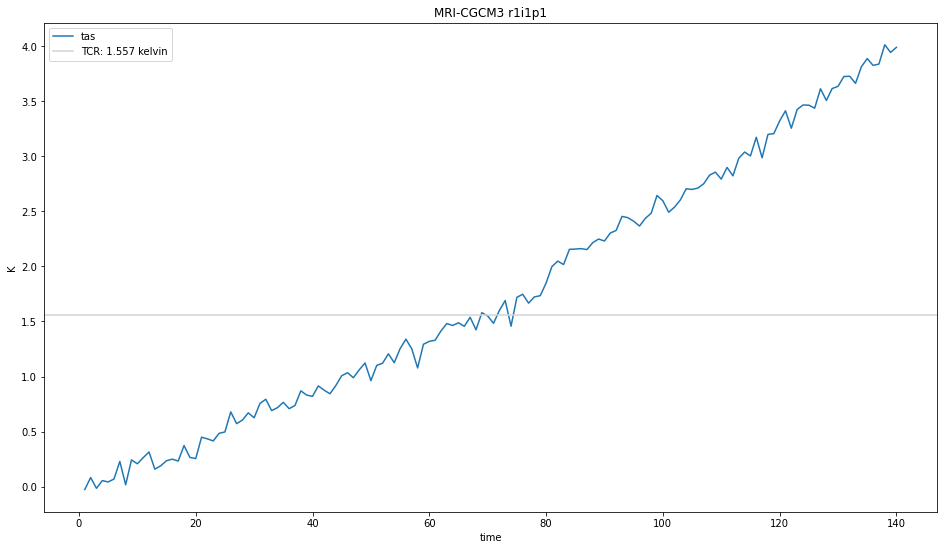

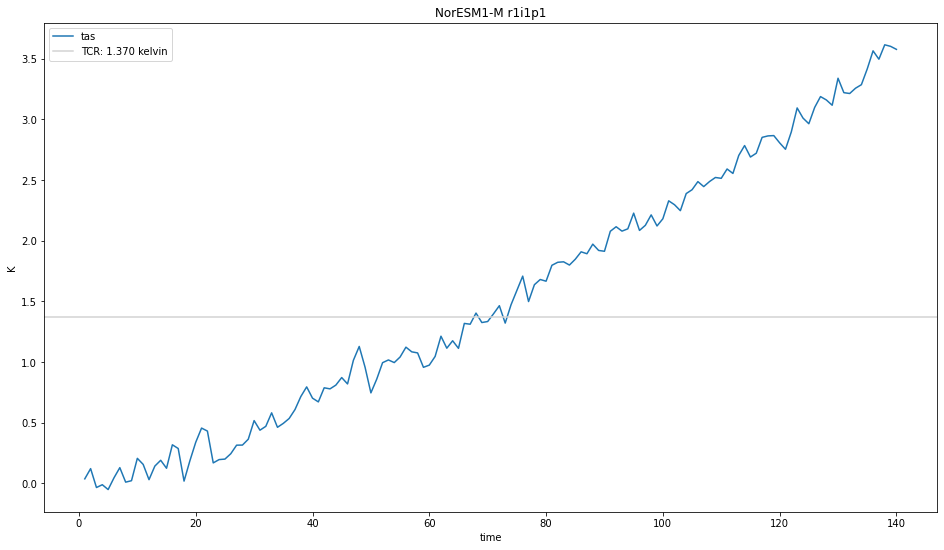

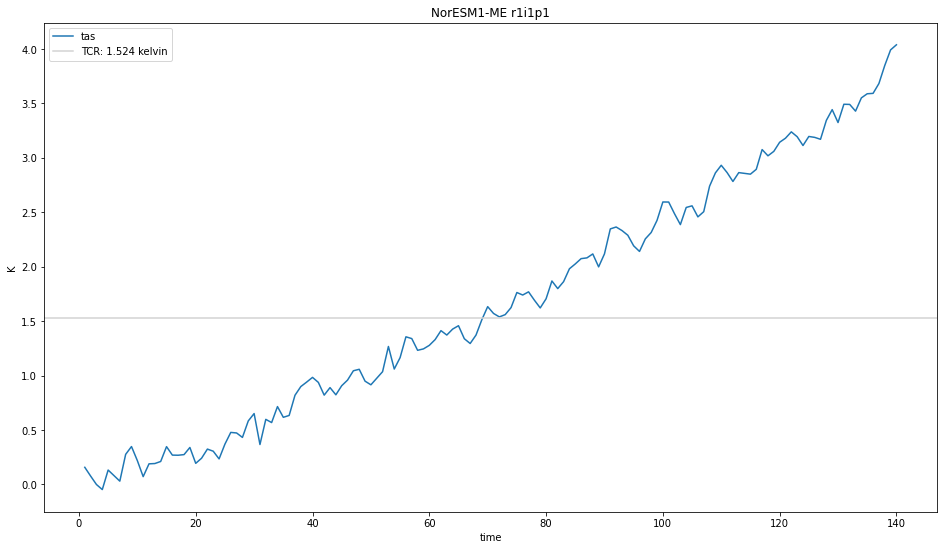

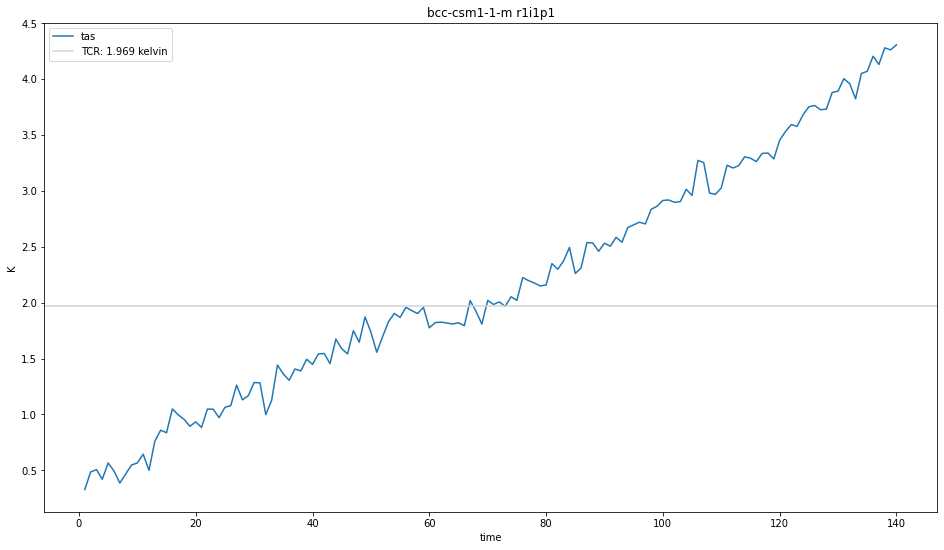

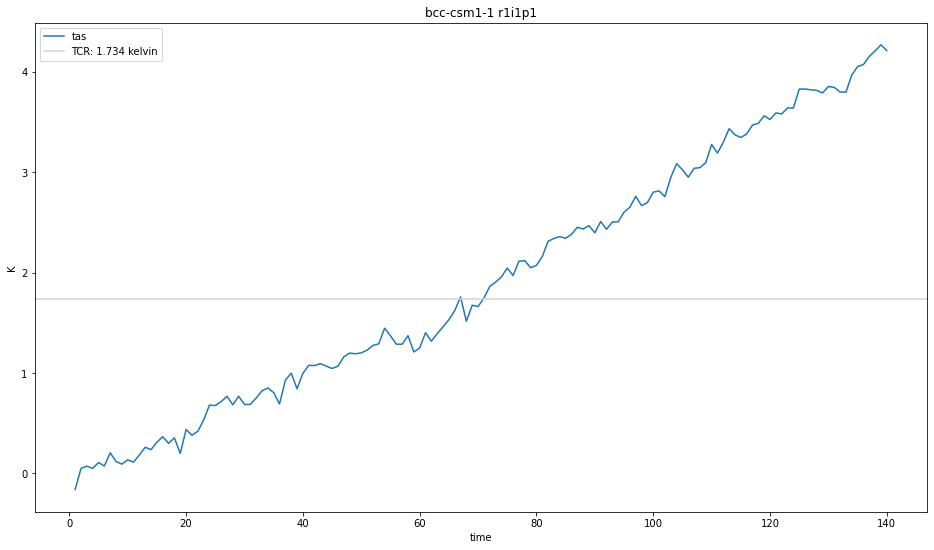

<IPython.core.display.Javascript object>

In [11]:
out_table = {}

for f in tqdman.tqdm(onepctCO2_tas_files):
    if "cmip5" in f:
        load_kwargs = dict(drs="MarbleCMIP5")
    else:
        load_kwargs = dict(drs="CMIP6Output")

    tas = netcdf_scm.io.load_mag_file(f, **load_kwargs).filter(
        region="World", variable="tas"
    )
    tas = force_first_year(tas)
    assert tas.metadata["normalisation method"] == "21-yr-running-mean"

    climate_model = tas.get_unique_meta("climate_model", no_duplicates=True)
    member_id = tas.get_unique_meta("member_id", no_duplicates=True)
    cmip6 = "CMIP6" in tas.metadata["(child) netcdf-scm crunched file"]

    fig = plt.figure(figsize=(16, 9))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

    ax1 = fig.add_subplot(spec[0, 0])

    tas.time_mean("AC").lineplot(hue="variable", time_axis="year", ax=ax1)
    tas_units = tas.get_unique_meta("unit", no_duplicates=True)

    tcr = tas.filter(year=range(60, 81)).timeseries().mean().mean() * unit_registry(
        tas_units
    )
    ax1.axhline(tcr.magnitude, color="lightgray", label="TCR: {:.3f}".format(tcr))
    ax1.legend()
    ax1.set_title("{} {}".format(climate_model, member_id))
    plt.show()

    out_dict = {
        "climate_model": climate_model,
        "member_id": member_id,
        "mip_era": "CMIP6" if cmip6 else "CMIP5",
        "tcr": tcr,
    }
    for k, v in out_dict.items():
        try:
            val = v.magnitude
            unit = v.units
            key = "{} ({})".format(k, unit)
        except AttributeError:
            key = k
            val = v

        if key in out_table:
            out_table[key].append(val)
        else:
            out_table[key] = [val]

out_table = pd.DataFrame(out_table)

In [12]:
len(out_table[out_table["mip_era"] == "CMIP6"]["climate_model"].unique())

33

<IPython.core.display.Javascript object>

In [13]:
len(out_table[out_table["mip_era"] == "CMIP5"]["climate_model"].unique())

24

<IPython.core.display.Javascript object>

In [14]:
len(out_table["climate_model"].unique())

57

<IPython.core.display.Javascript object>

In [15]:
out_table.head()

climate_model member_id mip_era  tcr (kelvin)
0  AWI-CM-1-1-MR  r1i1p1f1   CMIP6      2.051891
1    BCC-CSM2-MR  r1i1p1f1   CMIP6      1.577663
2       BCC-ESM1  r1i1p1f1   CMIP6      1.755439
3    CAMS-CSM1-0  r1i1p1f1   CMIP6      1.722427
4    CAMS-CSM1-0  r2i1p1f1   CMIP6      1.731453

<IPython.core.display.Javascript object>

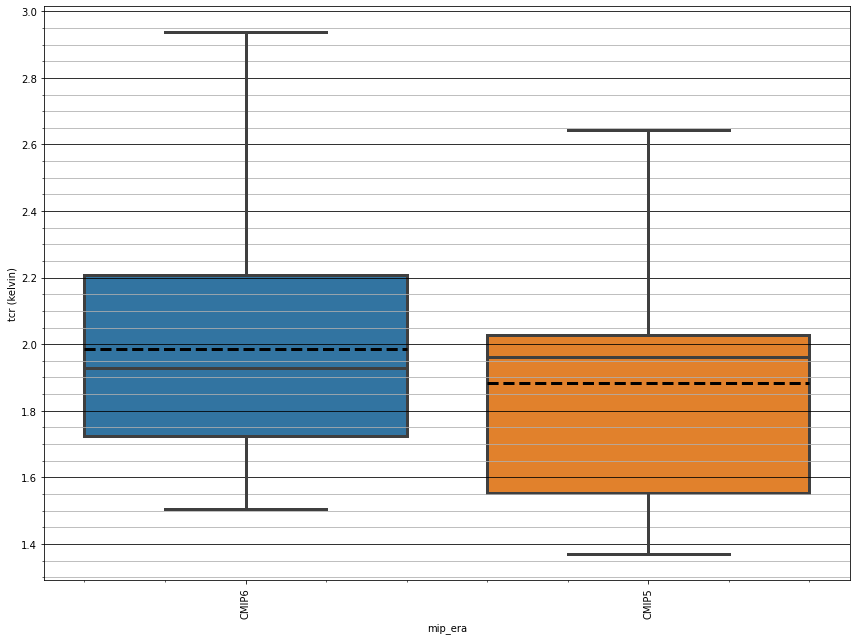

<IPython.core.display.Javascript object>

In [16]:
ax = plt.figure(figsize=(12, 9)).add_subplot(111)
sns.boxplot(
    data=out_table.groupby(["climate_model", "mip_era"]).mean().reset_index(),
    x="mip_era",
    y="tcr (kelvin)",
    linewidth=3,
    meanline=True,
    showmeans=True,
    meanprops={"color": "k", "linestyle": "--", "linewidth": 3},
    ax=ax,
)
ax.grid(which="major", axis="y", color="black", zorder=1)
ax.grid(which="minor", axis="y", zorder=1)
ax.minorticks_on()
plt.xticks(rotation=90)
plt.tight_layout()

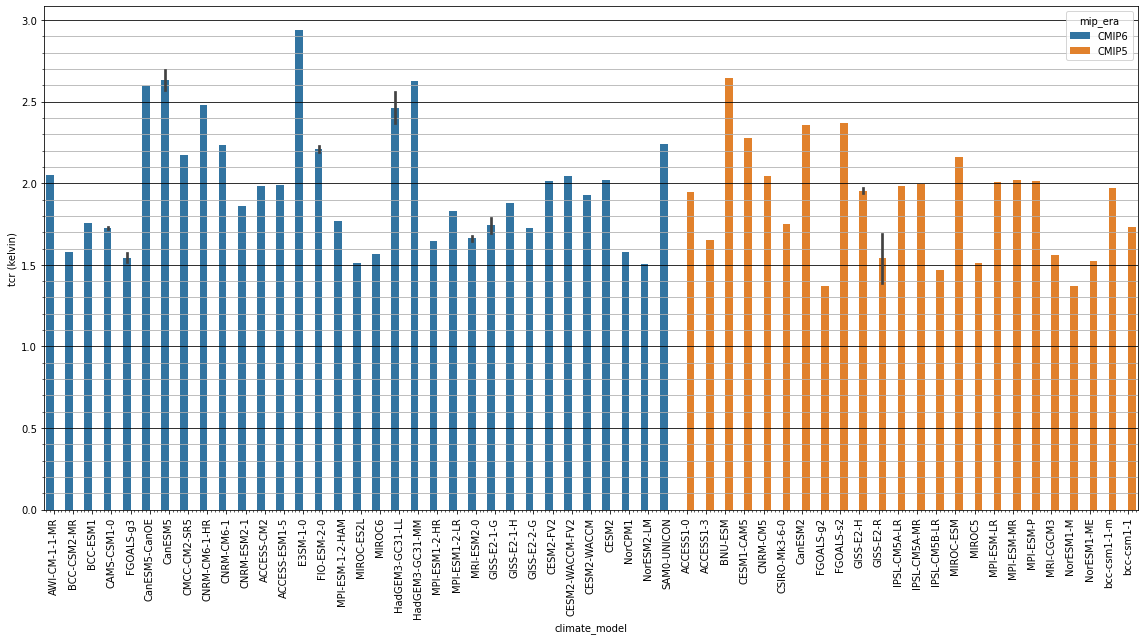

<IPython.core.display.Javascript object>

In [17]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
sns.barplot(
    data=out_table, hue="mip_era", x="climate_model", y="tcr (kelvin)", ci="sd", ax=ax
)
ax.grid(which="major", axis="y", color="k")
ax.grid(which="minor", axis="y")
ax.minorticks_on()
plt.xticks(rotation=90)
plt.tight_layout()

In [18]:
(
    out_table.groupby("climate_model").std() / out_table.groupby("climate_model").mean()
).dropna() * 100

tcr (kelvin)
climate_model                
CAMS-CSM1-0          0.369603
CanESM5              2.501632
FGOALS-g3            2.174500
FIO-ESM-2-0          1.107924
GISS-E2-1-G          3.066822
GISS-E2-H            1.203053
GISS-E2-R           13.925967
HadGEM3-GC31-LL      4.322626
MRI-ESM2-0           1.423472

<IPython.core.display.Javascript object>

In [19]:
out_table

climate_model member_id mip_era  tcr (kelvin)
0   AWI-CM-1-1-MR  r1i1p1f1   CMIP6      2.051891
1     BCC-CSM2-MR  r1i1p1f1   CMIP6      1.577663
2        BCC-ESM1  r1i1p1f1   CMIP6      1.755439
3     CAMS-CSM1-0  r1i1p1f1   CMIP6      1.722427
4     CAMS-CSM1-0  r2i1p1f1   CMIP6      1.731453
..            ...       ...     ...           ...
71      MRI-CGCM3    r1i1p1   CMIP5      1.557230
72      NorESM1-M    r1i1p1   CMIP5      1.369517
73     NorESM1-ME    r1i1p1   CMIP5      1.524440
74   bcc-csm1-1-m    r1i1p1   CMIP5      1.969150
75     bcc-csm1-1    r1i1p1   CMIP5      1.733650

[76 rows x 4 columns]

<IPython.core.display.Javascript object>